In [24]:
# Install NetworkX
# import sys
# !{sys.executable} -m pip install networkx==2.3

In [25]:
# Install matplotlib
# !{sys.executable} -m pip install matplotlib

In [80]:
# Imports
import sys
import math
import unittest
import networkx as nx
from itertools import combinations
import matplotlib.pyplot as plt

import pprint
pp = pprint.PrettyPrinter(indent=4)

In [84]:
G = nx.Graph() #tworzę graf

x1=0
x2=1
y1=0
y2=1
z1=0
z2=1

# Typ wierzchołka musi być wyróżniony
# w tym podejdziu zwykły wierzchołek zaczyna się na v, a hanging node na h
# jak widać w kodzie poniżej identyfikujemy typ po pierwszej literze

#           id,   x,    y,    z
G.add_node("v1", x=x1, y=y1, z=z1) #dodajemy wierzchołek
G.add_node("v2", x=x2, y=x2, z=z2) #dodajemy drugi wierzchołek
G.add_edge("v2", "v1") #dodajemy krawędź między wierzchołkami

v1 = G.nodes["v1"] #pobieramy wierzchołek który będzie nas interesował w kontekście krawędzi
v2 = G.nodes["v2"] #drugi wierzchołek krawędzi
attrs = {} #tak dodajemy atrybuty dla krawędzi, a krawędź ma atrybuty l i b
nx.set_edge_attributes(G, attrs) #aplikujemy atrybuty na krawędź

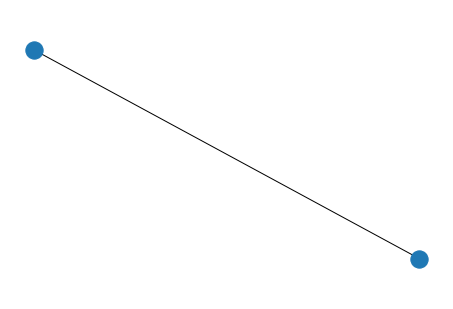

In [85]:
nx.draw(G)
plt.show()

zadanie polega na wyszukaniu w grafie, który został podany w sposób podany wyżej grafu, który spełnia warunki zadania

trójkąt o którym mowa może mieć hanging node, czyli specyficzny werzchołek, z którego nie ma połączenia do wnętrza, a który leży pomiędzy krawędziami

każde zadanie może mieć inne warunki na ilość hanging nodów

na wejście dostajemy id wierzchołka I, czyli tego środkowego

algorytm postępowania:

1. dostajemy i oraz G
2. znajdujemy sąsiadów i jeśli sąsiadów jest liczba mniejsza niż 3 to zwracamy false
3. jeśli jest 3 sąsiadów to określ trójkąt czyli połącznia między v1 v2 v3
4. L1=neighbours (v1, G)
5. L2=neighbours (v2, G)
6. if v1 należy do L2 i v2 należy do L1 (czyli jeśli jest pojedyncza krawędź) zwróć ją
7. else common=L1 przecięcie L2 i jeśli neighbour v1 jest hanging node i należy do common to zwróć dwie krawędzie - v1 z h i v2 z h, wpp. zwróć false

In [29]:
# Funkcja do budowania dicta ze współrzędnymi
# Taki dict jest wymagany przez funkcję rysującą
# jeżeli chcemy mieć poprawne rozmieszczenie
def build_pos_dict(G):
    xs = nx.get_node_attributes(G,'x')
    ys = nx.get_node_attributes(G,'y')

    keys = xs.keys()
    values = zip(xs.values(), ys.values())
    pos = dict(zip(keys, values))
    
    return pos

In [30]:
# Na wejściu dostajemy jakiś bardzo duży graf, który jest jakoś tam reprezentowany (na razie nie wiemy jak).
# Zakładamy jednak że mamy jakieś funkcje które parsują wejście i zwracają nam wszystkie potrzebne 
# dane, np w postaci dicta.
# Ogólnie to możemy założyć że wszystkie dane potrzebne do zbudowania grafu wejściowego są nam po prostu dostępne
# Poniżej graf na którym można testować swoje rozwiązanie

def get_test_graph():
    G = nx.Graph()
    vertices = {"v1": (0, 30, 0), 
                "v2": (10, 30, 0), 
                "v3": (9, 40, 0), 
                "h1": (5, 30, 0), 
                "h2": (9.5, 35, 0), 
                "i1": (7, 34, 0), 
                "v4": (6, 15, 0), 
                "i2": (4, 24, 0),
                "i3": (7, 24, 0)}
    for n, c in vertices.items():
        G.add_node(n, x=c[0], y=c[1], z=c[2])

    attrs = {"i1": {'R': True}, 
             "i2": {'R': False}, 
             "i3": {'R': False}}

    G.add_edge("v1", "h1", length = 5, name = 'e1')
    G.add_edge("v2", "h2", length = 5.0249, name = 'e2')
    G.add_edge("v2", "h1", length = 5, name = 'e3')
    G.add_edge("v3", "h2", length = 5.0249, name = 'e4')
    G.add_edge("v3", "v1", length = 13.4536, name = 'e5')
    G.add_edge("v1", "i1", length = 8.0623, name = 'e6')
    G.add_edge("v2", "i1", length = 5, name = 'e7')
    G.add_edge("v3", "i1", length = 6.3246, name = 'e8')
    G.add_edge("v4", "v1", length = 16.1555, name = 'e9')
    G.add_edge("v4", "v2", length = 15.5242, name = 'e10')
    G.add_edge("v4", "h1", length = 15.0333, name = 'e11')
    G.add_edge("v1", "i2", length = 7.2111, name = 'e12')
    G.add_edge("h1", "i2", length = 6.0828, name = 'e13')
    G.add_edge("v4", "i2", length = 9.2195, name = 'e14')
    G.add_edge("i3", "v4", length = 9.0554, name = 'e15')
    G.add_edge("i3", "v2", length = 6.7082, name = 'e16')
    G.add_edge("i3", "h1", length = 6.3246, name = 'e17')
    
    nx.set_node_attributes(G, attrs)
    
    return G

# NetworkX: aby narysować graf z dobrym rozmieszczeniem, musimy przekazać
# sam graf oraz osobno dict z współrzędnymi (x,y)
G = get_test_graph()
nx.draw(G, build_pos_dict(G), with_labels = True)

powstał na górze graf przykładowy, który wskazał dr. Paszyński jako przykład, że jak z tym sobie program poradzi to ze wszystkim sobie poradzi

# P1

In [31]:
def get_valid_p1_graph():
    G = nx.Graph()
    vertices = {
        "v1": (0, 0, 0),
        "v2": (12, 0, 0),
        "h3": (6, 8, 0),
        "i1": (6, 4, 0)
    }

    for n, c in vertices.items():
        G.add_node(n, x=c[0], y=c[1], z=c[2])

    i1_attrs = {"i1": {'R': True}}
    nx.set_node_attributes(G, i1_attrs)

    G.add_edge("v1", "v2", length=12, B=True)
    G.add_edge("v2", "h3", length=10, B=False)
    G.add_edge("h3", "v1", length=10, B=False)
    G.add_edge("i1", "v1", length=5, B=False)
    G.add_edge("i1", "v2", length=5, B=False)
    G.add_edge("i1", "h3", length=4, B=False)

    return G


G = get_valid_p1_graph()
nx.draw(G, build_pos_dict(G), with_labels=True)

In [32]:
# def transform_p1(G: nx.Graph, i: str) -> bool:
#     if len(list(G.neighbors(i))) != 3:
#         print("Not enough neighbours")
#         return False

#     # Temporary assign neighbours to v1, v2, v3 this may not reflect the reality.
#     v1 = list(G.neighbors(i))[0]
#     v2 = list(G.neighbors(i))[1]
#     v3 = list(G.neighbors(i))[2]

#     # Find hanging node, this will tell the orientation of the graph.
#     h = [node for node in [v1, v2, v3] if node.startswith('h')]
#     if len(h) != 1:
#         print("This transformation requires one hanging node")
#         return False
#     h = h[0]

#     # Reassign nodes, we want to treat v1 and v2 exactly like on the graph from PDF
#     v1, v2 = [node for node in [v1, v2, v3] if node != h]

#     # Get nodes (networkx objects)
#     h_node = G.nodes[h]
#     i_node = G.nodes[i]
#     v1_node = G.nodes[v1]
#     v2_node = G.nodes[v2]

#     e1 = G.edges[v1, v2]
#     e2 = G.edges[v2, h]
#     e3 = G.edges[v1, h]

#     transformable = i_node['R'] and e1['B'] and e1['length'] >= e2['length'] and e1['length'] >= e2['length']
#     if not transformable:
#         print("Condition failed")
#         return False

#     # Now transformation begins
#     # Calculate all variables
#     l4 = e1["length"] / 2
#     b4 = e1['B']
#     l5 = e1["length"] / 2
#     b5 = e1['B']
#     x4 = (v1_node['x'] + v2_node['x']) / 2
#     y4 = (v1_node['y'] + v2_node['y']) / 2
#     z4 = (v1_node['z'] + v2_node['z']) / 2
#     l6 = math.sqrt(math.pow(h_node['x'] - x4, 2) + math.pow(h_node['y'] - y4, 2) + math.pow(h_node['z'] - z4, 2))
#     r2 = False
#     r3 = False
#     b6 = False

#     # Modify the graph
#     G.remove_edge(v1, v2)
#     G.remove_node(i)

#     last_v_node_name = next((x for x in sorted(list(G.nodes), reverse=True) if x.startswith('v')), None)
#     current_number = int(last_v_node_name[1:]) + 1
#     new_v_node_name = f"v{current_number}"
#     G.add_node(new_v_node_name, x=x4, y=y4, z=z4)

#     G.add_edge(v1, new_v_node_name, length=l4, B=b4)
#     G.add_edge(new_v_node_name, v2, length=l5, B=b5)

#     G.add_edge(h, new_v_node_name, length=l6, B=b6)

#     i2 = f"i{current_number}"
#     x_i2 = (G.node[new_v_node_name]['x']) / 3 + (v1_node['x']) / 3 + (h_node['x']) / 3
#     y_i2 = (G.node[new_v_node_name]['y']) / 3 + (v1_node['y']) / 3 + (h_node['y']) / 3
#     z_i2 = (G.node[new_v_node_name]['z']) / 3 + (v1_node['z']) / 3 + (h_node['z']) / 3
#     G.add_node(i2, R=r2, x=x_i2, y=y_i2, z=z_i2)

#     G.add_edge(i2, v1)
#     G.add_edge(i2, new_v_node_name)
#     G.add_edge(i2, h)

#     i3 = f"i{current_number + 1}"
#     x_i3 = (G.node[new_v_node_name]['x']) / 3 + (v2_node['x']) / 3 + (h_node['x']) / 3
#     y_i3 = (G.node[new_v_node_name]['y']) / 3 + (v2_node['y']) / 3 + (h_node['y']) / 3
#     z_i3 = (G.node[new_v_node_name]['z']) / 3 + (v2_node['z']) / 3 + (h_node['z']) / 3
#     G.add_node(i3, R=r3, x=x_i3, y=y_i3, z=z_i3)

#     G.add_edge(i3, v2)
#     G.add_edge(i3, new_v_node_name)
#     G.add_edge(i3, h)

#     return True


# G = get_valid_p1_graph()
# transfrom_p1(G, "i1")
# nx.draw(G, build_pos_dict(G), with_labels=True)

NameError: name 'transfrom_p1' is not defined

## P1 tests

In [33]:
G = get_test_graph()
nx.draw(G, build_pos_dict(G), with_labels=True)

In [34]:
def p1_test(G):
    i_nodes = list(filter(lambda x: x.startswith('i'), G.nodes()))
    for i_node in i_nodes:
        transform_p1(G, i_node)

In [35]:
p1_test(G)
nx.draw(G, build_pos_dict(G), with_labels=True)

This transformation requires one hanging node
Condition failed
Condition failed


In [36]:
# def get_test_graph_p1():
#     G = nx.Graph()
#     vertices = {"v1": (0, 30, 0), 
#                 "v2": (10, 30, 0), 
#                 "v3": (9, 40, 0), 
#                 "h1": (5, 30, 0), 
#                 "h2": (9.5, 35, 0), 
#                 "i1": (7, 34, 0), 
#                 "v4": (6, 15, 0), 
#                 "i2": (4, 24, 0),
#                 "i3": (7, 24, 0)}
#     for n, c in vertices.items():
#         G.add_node(n, x=c[0], y=c[1], z=c[2])

#     attrs = {"i1": {'R': True}, 
#              "i2": {'R': True}, 
#              "i3": {'R': True}}

#     G.add_edge("v1", "h1", length = 5, name = 'e1', B=False)
#     G.add_edge("v2", "h2", length = 5.0249, name = 'e2', B=False)
#     G.add_edge("v2", "h1", length = 5, name = 'e3', B=False)
#     G.add_edge("v3", "h2", length = 5.0249, name = 'e4', B=False)
#     G.add_edge("v3", "v1", length = 13.4536, name = 'e5', B=False)
#     G.add_edge("v1", "i1", length = 8.0623, name = 'e6', B=False)
#     G.add_edge("v2", "i1", length = 5, name = 'e7', B=False)
#     G.add_edge("v3", "i1", length = 6.3246, name = 'e8', B=False)
#     G.add_edge("v4", "v1", length = 16.1555, name = 'e9', B=True)
#     G.add_edge("v4", "v2", length = 15.5242, name = 'e10', B=False)
#     G.add_edge("v4", "h1", length = 15.0333, name = 'e11', B=False)
#     G.add_edge("v1", "i2", length = 7.2111, name = 'e12', B=False)
#     G.add_edge("h1", "i2", length = 6.0828, name = 'e13', B=False)
#     G.add_edge("v4", "i2", length = 9.2195, name = 'e14', B=False)
#     G.add_edge("i3", "v4", length = 9.0554, name = 'e15', B=False)
#     G.add_edge("i3", "v2", length = 6.7082, name = 'e16', B=False)
#     G.add_edge("i3", "h1", length = 6.3246, name = 'e17', B=False)
    
#     nx.set_node_attributes(G, attrs)
    
#     return G

# G = get_test_graph_p1()
# nx.draw(G, build_pos_dict(G), with_labels = True)

In [37]:
p1_test(G)
nx.draw(G, build_pos_dict(G), with_labels=True)

This transformation requires one hanging node
Condition failed


In [196]:
# def get_test_graph_p1():
#     G = nx.Graph()
#     vertices = {"v1": (0, 30, 0), 
#                 "v2": (10, 30, 0), 
#                 "v3": (9, 40, 0), 
#                 "h1": (5, 30, 0), 
#                 "h2": (9.5, 35, 0), 
#                 "i1": (7, 34, 0), 
#                 "v4": (6, 15, 0), 
#                 "i2": (4, 24, 0),
#                 "i3": (7, 24, 0)}
#     for n, c in vertices.items():
#         G.add_node(n, x=c[0], y=c[1], z=c[2])

#     attrs = {"i1": {'R': True}, 
#              "i2": {'R': True}, 
#              "i3": {'R': True}}

#     G.add_edge("v1", "h1", length = 5, name = 'e1', B=False)
#     G.add_edge("v2", "h2", length = 5.0249, name = 'e2', B=False)
#     G.add_edge("v2", "h1", length = 5, name = 'e3', B=False)
#     G.add_edge("v3", "h2", length = 5.0249, name = 'e4', B=False)
#     G.add_edge("v3", "v1", length = 13.4536, name = 'e5', B=False)
#     G.add_edge("v1", "i1", length = 8.0623, name = 'e6', B=False)
#     G.add_edge("v2", "i1", length = 5, name = 'e7', B=False)
#     G.add_edge("v3", "i1", length = 6.3246, name = 'e8', B=False)
#     G.add_edge("v4", "v1", length = 16.1555, name = 'e9', B=True)
#     G.add_edge("v4", "v2", length = 15.5242, name = 'e10', B=True)
#     G.add_edge("v4", "h1", length = 15.0333, name = 'e11', B=False)
#     G.add_edge("v1", "i2", length = 7.2111, name = 'e12', B=False)
#     G.add_edge("h1", "i2", length = 6.0828, name = 'e13', B=False)
#     G.add_edge("v4", "i2", length = 9.2195, name = 'e14', B=False)
#     G.add_edge("i3", "v4", length = 9.0554, name = 'e15', B=False)
#     G.add_edge("i3", "v2", length = 6.7082, name = 'e16', B=False)
#     G.add_edge("i3", "h1", length = 6.3246, name = 'e17', B=False)
    
#     nx.set_node_attributes(G, attrs)
    
#     return G

# G = get_test_graph_p1()
nx.draw(G, build_pos_dict(G), with_labels = True)

In [148]:
p1_test(G)
nx.draw(G, build_pos_dict(G), with_labels=True)

This transformation requires one hanging node


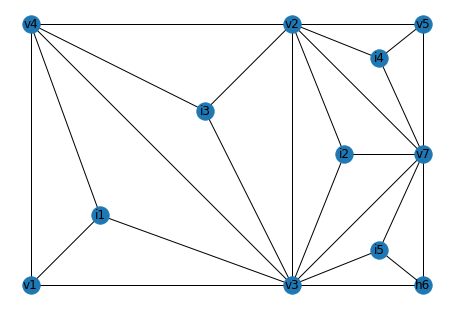

In [204]:
#Po puszczeniu wszystkich P1, P2, .., od tego miejsca powinniśmy uruchamiać, żeby przetestować


pos = {"v1": (0,0), "v2": (30, 30), "v3": (30, 0), "v4":(0, 30), "v5":(45, 30), "h6":(45, 0), "v7":(45, 15),
       "i1":(8, 8), "i2":(36, 15), "i3":(20, 20), "i4":(40, 26), "i5":(40, 4)} 
attrs = {"i4": {'R': True}, "i5":{'R': True}, "i3":{'R': False}, "i1":{'R': False}, "i2":{'R': False}}

G = nx.Graph()
for n, c in pos.items():
    G.add_node(n, x=c[0], y=c[1], z=0)
G.add_nodes_from(pos.keys())
G.add_edge("v1", "v4", length = 30, name = 'e1', B=True)
G.add_edge("v3", "v1", length = 30, name = 'e2', B=True)
G.add_edge("v3", "h6", length = 15, name = 'e3', B=False)
G.add_edge("h6", "v7", length = 15, name = 'e4', B=False)
G.add_edge("v7", "v5", length = 15, name = 'e5', B=True)
G.add_edge("v5", "v2", length = 15, name = 'e6', B=True)
G.add_edge("v2", "v4", length = 30, name = 'e7', B=True)
G.add_edge("v4", "v3", length = 42.42, name = 'e8', B=False)
G.add_edge("v3", "v2", length = 30, name = 'e9', B=False)
G.add_edge("v2", "v7", length = 21.21, name = 'e10', B=False)
G.add_edge("v3", "v7", length = 21.21, name = 'e18', B=True)
G.add_edge("v3", "i2", length = 1, name = 'e11', B=False)
G.add_edge("v2", "i2", length = 1, name = 'e12', B=False)
G.add_edge("v7", "i2", length = 1, name = 'e13', B=False)
G.add_edge("v4", "i3", length = 1, name = 'e14', B=False)
G.add_edge("i3", "v2", length = 1, name = 'e15', B=False)
G.add_edge("i3", "v3", length = 1, name = 'e16', B=False)
G.add_edge("i1", "v1", length = 1, name = 'e17', B=False)
G.add_edge("i1", "v3", length = 1, name = 'e19', B=False)
G.add_edge("i1", "v4", length = 1, name = 'e20', B=False)
G.add_edge("i4", "v5", length = 1, name = 'e21', B=False)
G.add_edge("i4", "v7", length = 1, name = 'e22', B=False)
G.add_edge("i4", "v2", length = 1, name = 'e23', B=False)
G.add_edge("i5", "v7", length = 1, name = 'e24', B=False)
G.add_edge("i5", "h6", length = 1, name = 'e25', B=False)
G.add_edge("i5", "v3", length = 1, name = 'e26', B=False)


nx.set_node_attributes(G, attrs)
nx.draw(G, build_pos_dict(G), with_labels = True)
plt.show()

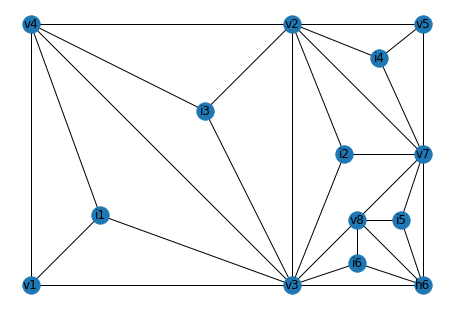

In [205]:
transform_p1(G, "i5")
nx.draw(G, build_pos_dict(G), with_labels = True)
plt.show()

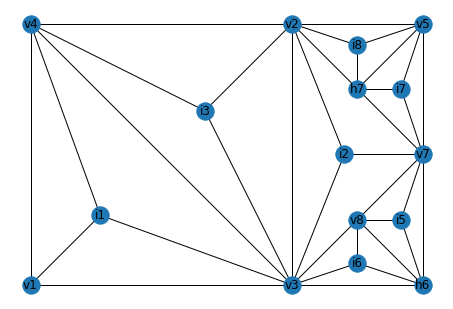

In [206]:
transform_p2(G, "i4")
nx.draw(G, build_pos_dict(G), with_labels = True)
plt.show()

{'length': 30, 'name': 'e9', 'B': False}
[{'length': 10.605, 'B': False}, {'length': 10.605, 'B': False}]
[{'length': 15, 'name': 'e3', 'B': False}, {'length': 15, 'name': 'e4', 'B': False}]
{'length': 30, 'name': 'e9', 'B': False}
nowy punkt v będzie się nazywał: h9
nowy punkt i będzie się nazywał: i9
nowy punkt i będzie się nazywał: i10
nowy wierzcholek ma byc miedzy v1 a v2
True


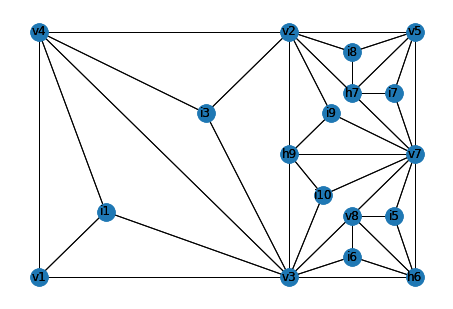

In [207]:
print(transform_p7(G, "i2"))
nx.draw(G, build_pos_dict(G), with_labels = True)
plt.show()

1:  30


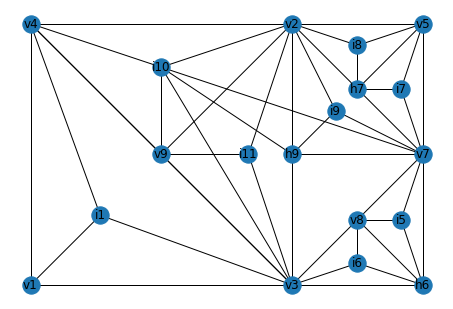

In [209]:
transform_p5(G, "i3")
nx.draw(G, build_pos_dict(G), with_labels = True)
plt.show()

# P1

In [127]:
def transform_p1(G: nx.Graph, i: str) -> bool:
    if len(list(G.neighbors(i))) != 3:
        print("Not enough neighbours")
        return False

    # Temporary assign neighbours to v1, v2, v3 this may not reflect the reality.
    v1 = list(G.neighbors(i))[0]
    v2 = list(G.neighbors(i))[1]
    v3 = list(G.neighbors(i))[2]

    # Find hanging node, this will tell the orientation of the graph.
    h = [node for node in [v1, v2, v3] if node.startswith('h')]
    if len(h) != 1:
        print("This transformation requires one hanging node")
        return False
    h = h[0]

    # Reassign nodes, we want to treat v1 and v2 exactly like on the graph from PDF
    v1, v2 = [node for node in [v1, v2, v3] if node != h]

    # Get nodes (networkx objects)
    h_node = G.nodes[h]
    i_node = G.nodes[i]
    v1_node = G.nodes[v1]
    v2_node = G.nodes[v2]

    e1 = G.edges[v1, v2]
    e2 = G.edges[v2, h]
    e3 = G.edges[v1, h]

    transformable = i_node['R'] and e1['B'] and e1['length'] >= e2['length'] and e1['length'] >= e2['length']
    if not transformable:
        print("Condition failed")
        return False

    # Now transformation begins
    # Calculate all variables
    l4 = e1["length"] / 2
    b4 = e1['B']
    l5 = e1["length"] / 2
    b5 = e1['B']
    x4 = (v1_node['x'] + v2_node['x']) / 2
    y4 = (v1_node['y'] + v2_node['y']) / 2
    z4 = (v1_node['z'] + v2_node['z']) / 2
    l6 = math.sqrt(math.pow(h_node['x'] - x4, 2) + math.pow(h_node['y'] - y4, 2) + math.pow(h_node['z'] - z4, 2))
    r2 = False
    r3 = False
    b6 = False

    # Modify the graph
    G.remove_edge(v1, v2)
    G.remove_node(i)

    last_v_node_name = next((x for x in sorted(list(G.nodes), reverse=True) if x.startswith('v')), None)
    current_number = int(last_v_node_name[1:]) + 1
    new_v_node_name = f"v{current_number}"
    G.add_node(new_v_node_name, x=x4, y=y4, z=z4)

    G.add_edge(v1, new_v_node_name, length=l4, B=b4)
    G.add_edge(new_v_node_name, v2, length=l5, B=b5)

    G.add_edge(h, new_v_node_name, length=l6, B=b6)

    last_h_node_name = next((x for x in sorted(list(G.nodes), reverse=True) if x.startswith('i')), None)
    if last_h_node_name:
        current_number = int(last_h_node_name[1:]) + 1
    else:
        current_number = 1
    i2 = f"i{current_number}"
    x_i2 = (G.node[new_v_node_name]['x']) / 3 + (v1_node['x']) / 3 + (h_node['x']) / 3
    y_i2 = (G.node[new_v_node_name]['y']) / 3 + (v1_node['y']) / 3 + (h_node['y']) / 3
    z_i2 = (G.node[new_v_node_name]['z']) / 3 + (v1_node['z']) / 3 + (h_node['z']) / 3
    G.add_node(i2, R=r2, x=x_i2, y=y_i2, z=z_i2)

    G.add_edge(i2, v1)
    G.add_edge(i2, new_v_node_name)
    G.add_edge(i2, h)

    i3 = f"i{current_number + 1}"
    x_i3 = (G.node[new_v_node_name]['x']) / 3 + (v2_node['x']) / 3 + (h_node['x']) / 3
    y_i3 = (G.node[new_v_node_name]['y']) / 3 + (v2_node['y']) / 3 + (h_node['y']) / 3
    z_i3 = (G.node[new_v_node_name]['z']) / 3 + (v2_node['z']) / 3 + (h_node['z']) / 3
    G.add_node(i3, R=r3, x=x_i3, y=y_i3, z=z_i3)

    G.add_edge(i3, v2)
    G.add_edge(i3, new_v_node_name)
    G.add_edge(i3, h)

    return True


G = get_valid_p1_graph()
transform_p1(G, "i1")
nx.draw(G, build_pos_dict(G), with_labels=True)

In [89]:
def get_test_graph_p1():
    G = nx.Graph()
    vertices = {"v1": (0, 30, 0), 
                "v2": (10, 30, 0), 
                "v3": (9, 40, 0), 
                "h1": (5, 30, 0), 
                "h2": (9.5, 35, 0), 
                "i1": (7, 34, 0), 
                "v4": (6, 15, 0), 
                "i2": (4, 24, 0),
                "i3": (7, 24, 0)}
    for n, c in vertices.items():
        G.add_node(n, x=c[0], y=c[1], z=c[2])

    attrs = {"i1": {'R': True}, 
             "i2": {'R': True}, 
             "i3": {'R': True}}

    G.add_edge("v1", "h1", length = 5, name = 'e1', B=False)
    G.add_edge("v2", "h2", length = 5.0249, name = 'e2', B=False)
    G.add_edge("v2", "h1", length = 5, name = 'e3', B=False)
    G.add_edge("v3", "h2", length = 5.0249, name = 'e4', B=False)
    G.add_edge("v3", "v1", length = 13.4536, name = 'e5', B=False)
    G.add_edge("v1", "i1", length = 8.0623, name = 'e6', B=False)
    G.add_edge("v2", "i1", length = 5, name = 'e7', B=False)
    G.add_edge("v3", "i1", length = 6.3246, name = 'e8', B=False)
    G.add_edge("v4", "v1", length = 16.1555, name = 'e9', B=True)
    G.add_edge("v4", "v2", length = 15.5242, name = 'e10', B=True)
    G.add_edge("v4", "h1", length = 15.0333, name = 'e11', B=False)
    G.add_edge("v1", "i2", length = 7.2111, name = 'e12', B=False)
    G.add_edge("h1", "i2", length = 6.0828, name = 'e13', B=False)
    G.add_edge("v4", "i2", length = 9.2195, name = 'e14', B=False)
    G.add_edge("i3", "v4", length = 9.0554, name = 'e15', B=False)
    G.add_edge("i3", "v2", length = 6.7082, name = 'e16', B=False)
    G.add_edge("i3", "h1", length = 6.3246, name = 'e17', B=False)
    
    nx.set_node_attributes(G, attrs)
    
    return G

G = get_test_graph_p1()
nx.draw(G, build_pos_dict(G), with_labels = True)

In [90]:
p1_test(G)
nx.draw(G, build_pos_dict(G), with_labels=True)

This transformation requires one hanging node


# P2

In [76]:
def prepare_P2_graph():
    G = nx.Graph()
    vertices = {
        "v1": (0, 0, 0),
        "v2": (12, 0, 0),
        "v3": (6, 8, 0),
        "i1": (6, 4, 0)
    }

    for n, c in vertices.items():
        G.add_node(n, x=c[0], y=c[1], z=c[2])

    i1_attrs = {"i1": {'R': True}}
    nx.set_node_attributes(G, i1_attrs)

    G.add_edge("v1", "v2", length=10, B=False)
    G.add_edge("v2", "v3", length=10, B=False)
    G.add_edge("v3", "v1", length=10, B=False)
    G.add_edge("i1", "v1", length=5, B=False)
    G.add_edge("i1", "v2", length=5, B=False)
    G.add_edge("i1", "v3", length=4, B=False)

    return G


G = prepare_P2_graph()
nx.draw(G, build_pos_dict(G), with_labels=True)

In [97]:
def calculateP2(v1, v2, v3, i, G):
    i_node = G.nodes[i]
    v1_node = G.nodes[v1]
    v2_node = G.nodes[v2]
    v3_node = G.nodes[v3]
    
    e1 = G.edges[v1, v2]
    e2 = G.edges[v2, v3]
    e3 = G.edges[v1, v3]

    #transformable = i_node['R'] and not e1['B'] and e1['length'] >= e2['length'] and e1['length'] >= e3['length'] and not ((e2['B'] and e2['length'] == e1['length'] or (e3['B'] and e3['length'] == e1['length'])))
    transformable = i_node['R'] and not e1['B'] and e1['length'] >= e2['length'] and e1['length'] >= e3['length']
    if not transformable:
        return False


    l4 = e1["length"] / 2
    b4 = e1['B']
    l5 = e1["length"] / 2
    b5 = e1['B']
    x4 = (v1_node['x'] + v2_node['x']) / 2
    y4 = (v1_node['y'] + v2_node['y']) / 2
    z4 = (v1_node['z'] + v2_node['z']) / 2
    l6 = math.sqrt(math.pow(v3_node['x'] - x4, 2) + math.pow(v3_node['y'] - y4, 2) + math.pow(v3_node['z'] - z4, 2))
    r2 = False
    r3 = False
    b6 = False


    G.remove_edge(v1, v2)
    G.remove_node(i)

    last_h_node_name = next((x for x in sorted(list(G.nodes), reverse=True) if x.startswith('h')), None)
    if last_h_node_name:
        next_number = int(last_h_node_name[1:]) + 1
    else:
        next_number = 1
        
    new_h_node_name = "h" + str(next_number)
    G.add_node(new_h_node_name, x=x4, y=y4, z=z4)

    G.add_edge(v1, new_h_node_name, length=l4, B=b4)
    G.add_edge(new_h_node_name, v2, length=l5, B=b5)

    G.add_edge(v3, new_h_node_name, length=l6, B=b6)

    last_i_node_name = next((x for x in sorted(list(G.nodes), reverse=True) if x.startswith('i')), None)
    if last_i_node_name:
        next_i_number = int(last_i_node_name[1:]) +1
    else:
        next_i_number = 1
        
    i2 = "i" + str(next_i_number)
    x_i2 = (G.node[new_h_node_name]['x']) / 3 + (v1_node['x']) / 3 + (v3_node['x']) / 3
    y_i2 = (G.node[new_h_node_name]['y']) / 3 + (v1_node['y']) / 3 + (v3_node['y']) / 3
    z_i2 = (G.node[new_h_node_name]['z']) / 3 + (v1_node['z']) / 3 + (v3_node['z']) / 3
    G.add_node(i2, R=r2, x=x_i2, y=y_i2, z=z_i2)

    G.add_edge(i2, v1)
    G.add_edge(i2, new_h_node_name)
    G.add_edge(i2, v3)
    
    i3 = "i" + str(next_i_number + 1)
    x_i3 = (G.node[new_h_node_name]['x']) / 3 + (v2_node['x']) / 3 + (v3_node['x']) / 3
    y_i3 = (G.node[new_h_node_name]['y']) / 3 + (v2_node['y']) / 3 + (v3_node['y']) / 3
    z_i3 = (G.node[new_h_node_name]['z']) / 3 + (v2_node['z']) / 3 + (v3_node['z']) / 3
    G.add_node(i3, R=r3, x=x_i3, y=y_i3, z=z_i3)

    G.add_edge(i3, v2)
    G.add_edge(i3, new_h_node_name)
    G.add_edge(i3, v3)
    
    return True

In [113]:
def transform_p2(G, i):
    if len(list(G.neighbors(i))) != 3:
        return False

    v1 = list(G.neighbors(i))[0]
    v2 = list(G.neighbors(i))[1]
    v3 = list(G.neighbors(i))[2]

    vList = [node for node in [v1, v2, v3] if node.startswith('v')]
    if len(vList) != 3:
        return False

    v1_nodes = [v1, v1, v2, v2, v3, v3]
    v2_nodes = [v2, v3, v1, v3, v1, v2]
    v3_nodes = [v3, v2, v3, v1, v2, v1]
    
    for x in range(6):
        if(calculateP2(v1_nodes[x], v2_nodes[x], v3_nodes[x], i, G)):
            return True
    
    return False


G = prepare_P2_graph()
transform_p2(G, "i1")
nx.draw(G, build_pos_dict(G), with_labels=True)

In [112]:
transform_p2(G, "i4")
nx.draw(G, pos, with_labels = True)
plt.show()

NetworkXError: Node 'h1' has no position.

In [79]:
def p2_test_graph():
    G = nx.Graph()
    vertices = {"v1": (0, 0, 0), 
                "v2": (100, 0, 0), 
                "v3": (0, 100, 0),
                "v4": (100, 100, 0),
                "v5": (150, 50, 0), 
                "v6": (50, 50, 0),
                "h2": (100, 50, 0),
                "i1": (50, 20, 0),
                "i2": (20, 50, 0),
                "i3": (75, 60, 0),
                "i4": (115, 40, 0),
                "i5": (115, 70, 0)
               }
    
    for n, c in vertices.items():
        G.add_node(n, x=c[0], y=c[1], z=c[2])

    attrs = {"i1": {'R': True}, 
             "i2": {'R': True}, 
             "i3": {'R': False},
             "i4": {'R': False},
             "i5": {'R': False}
            }
    nx.set_node_attributes(G, attrs)
    
    G.add_edge("v1", "v2", length = 100, B=False)
    G.add_edge("v1", "v3", length = 100, B=False)
    G.add_edge("v3", "v4", length = 100, B=False)  
    
    G.add_edge("v1", "v6", length = 70.7, B=False)
    G.add_edge("v2", "v6", length = 70.7, B=False)   
    G.add_edge("v3", "v6", length = 70.7, B=False)   

    G.add_edge("v2", "h2", length = 50, B=False)
    G.add_edge("v4", "h2", length = 50, B=False)
    
    G.add_edge("v5", "h2", length = 50, B=False)
    
    G.add_edge("v2", "v5", length = 35.4, B=False)
    G.add_edge("v4", "v5", length = 35.4, B=False)
    
    G.add_edge("i1", "v1", length = 35.4, B=False)
    G.add_edge("i1", "v2", length = 35.4, B=False)
    G.add_edge("i1", "v6", length = 35.4, B=False)
    
    G.add_edge("i2", "v1", length = 35.4, B=False)
    G.add_edge("i2", "v3", length = 35.4, B=False)
    G.add_edge("i2", "v6", length = 35.4, B=False)
    
    G.add_edge("i3", "v2", length = 35.4, B=False)
    G.add_edge("i3", "v3", length = 35.4, B=False)
    G.add_edge("i3", "v4", length = 35.4, B=False)
    G.add_edge("i3", "v6", length = 35.4, B=False)    
    
    G.add_edge("i4", "v2", length = 35.4, B=False)
    G.add_edge("i4", "v5", length = 35.4, B=False)
    G.add_edge("i4", "h2", length = 35.4, B=False)
    
    
    G.add_edge("i5", "v4", length = 35.4, B=False)
    G.add_edge("i5", "v5", length = 35.4, B=False)
    G.add_edge("i5", "h2", length = 35.4, B=False)
    
    
    return G

G = p2_test_graph()
nx.draw(G, build_pos_dict(G), with_labels = True)


In [44]:
G = p2_test_graph()
transform_p2(G, "i2")
nx.draw(G, build_pos_dict(G), with_labels = True)

# P3

In [67]:
def get_valid_p3_graph():
    G = nx.Graph()
    vertices = {
        "v1": (0, 100, 0),
        "v2": (100, 100, 0),
        "v3": (100, 0, 0),
        "v4": (0, 0, 0),
        "h1": (50, 50, 0),
        "i1": (50/3, 150/3, 0),
        "i2": (150/3, 50/3, 0),
        "i3": (200/3, 200/3, 0)
    }

    for n, c in vertices.items():
        G.add_node(n, x=c[0], y=c[1], z=c[2])

    i1_attrs = {"i1": {'R': False}}
    i2_attrs = {"i2": {'R': False}}
    i3_attrs = {"i3": {'R': True}}
    nx.set_node_attributes(G, i1_attrs)
    nx.set_node_attributes(G, i2_attrs)
    nx.set_node_attributes(G, i3_attrs)

    G.add_edge("v1", "v2", length=100, B=True)
    G.add_edge("v3", "v2", length=100, B=True)
    G.add_edge("v3", "v4", length=100, B=True)
    G.add_edge("v1", "v4", length=100, B=True)
    G.add_edge("h1", "v1", length=50*1.41, B=True)
    G.add_edge("h1", "v3", length=50*1.41, B=True)
    G.add_edge("h1", "v4", length=50*1.41, B=True)
    
    G.add_edge("i1", "v1", length=50, B=True)
    G.add_edge("i1", "h1", length=50, B=True)
    G.add_edge("i1", "v4", length=50, B=True)
    G.add_edge("i2", "h1", length=50, B=True)
    G.add_edge("i2", "v3", length=50, B=True)
    G.add_edge("i2", "v4", length=50, B=True)
    G.add_edge("i3", "v1", length=50, B=True)
    G.add_edge("i3", "v2", length=50, B=True)
    G.add_edge("i3", "v3", length=50, B=True)
    

    return G

In [68]:
def transfrom_P3(G: nx.Graph, i: str) -> bool:
#def transform_P3(G, i):
    # Jak i nie ma trzech sąsiadów to od razu wracamy
    if len(list(G.neighbors(i)))!=3:
        return False
    # będziemy szukać krawędzi która ma hanging node
    # to nam zoritentuje graf
    else:
        v1 = list(G.neighbors(i))[0]
        v2 = list(G.neighbors(i))[1]
        v3 = list(G.neighbors(i))[2]
        e1 = []
        e2 = []
        e3 = []
        edge_without_hanging_node_1=None
        edge_without_hanging_node_2=None
        
        hanging_node = None
        
        #szukam krawędzi między v1 i v2
        if (v1 in list(G.neighbors(v2))) and (v2 in list(G.neighbors(v1))):
            e1 = G.edges[v1, v2]
            if edge_without_hanging_node_1 == None:
                edge_without_hanging_node_1 = e1
        else:
            if any(t.startswith('h') for t in sorted(nx.common_neighbors(G, v1, v2))):
                h_edge=next((x for x in sorted(nx.common_neighbors(G, v1, v2)) if x.startswith('h')), None)
                e1.append(G.edges[v1,h_edge])
                e1.append(G.edges[v2,h_edge])
                for t in sorted(nx.common_neighbors(G, v2, v1)):
                    if t.startswith('h'):
                        hanging_node = t
            else:
                return False
          
        # między v2 i v3
        if (v2 in list(G.neighbors(v3))) and (v3 in list(G.neighbors(v2))):
            e2 = G.edges[v2, v3]
            if edge_without_hanging_node_1 == None:
                edge_without_hanging_node_1 = e2
            elif edge_without_hanging_node_2 == None:
                edge_without_hanging_node_2 = e2
            else:
                return False
        else:
            if any(t.startswith('h') for t in sorted(nx.common_neighbors(G, v2, v3))):
                h_edge=next((x for x in sorted(nx.common_neighbors(G, v2, v3)) if x.startswith('h')), None)
                e2.append(G.edges[v2,h_edge])
                e2.append(G.edges[v3,h_edge])
                for t in sorted(nx.common_neighbors(G, v2, v3)):
                    if t.startswith('h'):
                        hanging_node = t
            else:
                return False
            
        # między v3 i v1    
        if (v1 in list(G.neighbors(v3))) and (v3 in list(G.neighbors(v1))):
            e3 = G.edges[v1, v3]
            if edge_without_hanging_node_1 == None:
                edge_without_hanging_node_1 = e3
            elif edge_without_hanging_node_2 == None:
                edge_without_hanging_node_2 = e3
            else:
                return False
        else:
            if any(t.startswith('h') for t in sorted(nx.common_neighbors(G, v1, v3))):
                h_edge=next((x for x in sorted(nx.common_neighbors(G, v1, v3)) if x.startswith('h')), None)
                e3.append(G.edges[v1,h_edge])
                e3.append(G.edges[v3,h_edge])
                for t in sorted(nx.common_neighbors(G, v1, v3)):
                    if t.startswith('h'):
                        hanging_node = t
            else:
                return False
    print (e1)
    print (e2)
    print (e3)
    print (edge_without_hanging_node_1)
    print (edge_without_hanging_node_2)
    
    
    # sprawdzenie zadanego warunku:
    if (e1!=edge_without_hanging_node_1) and (e1!=edge_without_hanging_node_2):
        if not (((e1[0]['length'])+(e1[1]['length']) <= edge_without_hanging_node_1['length']) 
        and ((e1[0]['length'])+(e1[1]['length']) <= edge_without_hanging_node_2['length'])):
            print("1")
            return False
        
    if (e1!=edge_without_hanging_node_1) and (e1!=edge_without_hanging_node_2):
        if not (((e2[0]['length'])+(e2[1]['length']) <= edge_without_hanging_node_1['length']) 
        and ((e2[0]['length'])+(e2[1]['length']) <= edge_without_hanging_node_2['length'])):
            print("1")
            return False
        
    if (e1!=edge_without_hanging_node_1) and (e1!=edge_without_hanging_node_2):
        if not (((e3[0]['length'])+(e3[1]['length']) <= edge_without_hanging_node_1['length']) 
        and ((e3[0]['length'])+(e3[1]['length']) <= edge_without_hanging_node_2['length'])):
            print("1")
            return False
    
    # usuwam punkt I
    # usunięcie node'a od razu pociąga za sobą usunięcie jego krawędzi
    G.remove_node(i)
    
    #zamiana H na V
    last_v_index = next((x for x in sorted(list(G.nodes),reverse=True ) if x.startswith('v')), None)
    current_number = int(last_v_index[1:]) + 1
    new_v_node = "v" + str(current_number)
    old_h_node = hanging_node
    print ("nowy punkt v będzie się nazywał: " + new_v_node)
    mapping={old_h_node: new_v_node}
    G=nx.relabel_nodes(G,mapping, copy=False)
    
    #nowe punkty I:
    last_i_index = next((x for x in sorted(list(G.nodes),reverse=True ) if x.startswith('i')), None)
    current_number = int(last_i_index[1:]) + 1
    new_i_node = "i" + str(current_number)
    print ("nowy punkt i będzie się nazywał: " + new_i_node)
    
    last_i_index = next((x for x in sorted(list(G.nodes),reverse=True ) if x.startswith('i')), None)
    current_number = int(last_i_index[1:]) + 2
    new_i_node2 = "i" + str(current_number)
    print ("nowy punkt i będzie się nazywał: " + new_i_node2)
    
    
    if (e3!=edge_without_hanging_node_1 and e3!=edge_without_hanging_node_2):
        print ("hanging node miedzy v1 a v3")
        
        # add new_i1 positions
        new_x_for_i = (G.nodes[new_v_node]['x'])/3 + (G.nodes[v2]['x'])/3 + (G.nodes[v3]['x'])/3
        new_y_for_i = (G.nodes[new_v_node]['y'])/3 + (G.nodes[v2]['y'])/3 + (G.nodes[v3]['y'])/3
        new_z_for_i = (G.nodes[new_v_node]['z'])/3 + (G.nodes[v2]['z'])/3 + (G.nodes[v3]['z'])/3                                                                       
        G.add_node(new_i_node, x=new_x_for_i, y=new_y_for_i, z=new_z_for_i); 
        attrs[new_i_node] = {'R': False}
        G.add_edge(new_v_node, new_i_node)
        G.add_edge(v2, new_i_node)
        G.add_edge(v3, new_i_node)
        
        # add new_i2 positions
        new_x_for_i2 = (G.nodes[new_v_node]['x'])/3 + (G.nodes[v2]['x'])/3 + (G.nodes[v1]['x'])/3
        new_y_for_i2 = (G.nodes[new_v_node]['y'])/3 + (G.nodes[v2]['y'])/3 + (G.nodes[v1]['y'])/3
        new_z_for_i2 = (G.nodes[new_v_node]['z'])/3 + (G.nodes[v2]['z'])/3 + (G.nodes[v1]['z'])/3
        G.add_node(new_i_node2, x=new_x_for_i2, y=new_y_for_i2, z=new_z_for_i2);
        attrs[new_i_node2] = {'R': False}
        G.add_edge(new_v_node, new_i_node2)
        G.add_edge(v1, new_i_node2)
        G.add_edge(v2, new_i_node2)
    
        last_edge_length=math.sqrt(math.pow(G.nodes[v2]['x'] - G.nodes[new_v_node]['x'], 2) 
                                   + math.pow(G.nodes[v2]['y'] - G.nodes[new_v_node]['y'], 2) 
                                   + math.pow(G.nodes[v2]['z'] - G.nodes[new_v_node]['z'], 2))
        G.add_edge(new_v_node, v2)
        
    elif (e2!=edge_without_hanging_node_1 and e2!=edge_without_hanging_node_2):
        print ("hanging node miedzy v2 a v3")
        
        # add new_i1 positions
        new_x_for_i = (G.nodes[new_v_node]['x'])/3 + (G.nodes[v1]['x'])/3 + (G.nodes[v3]['x'])/3
        new_y_for_i = (G.nodes[new_v_node]['y'])/3 + (G.nodes[v1]['y'])/3 + (G.nodes[v3]['y'])/3
        new_z_for_i = (G.nodes[new_v_node]['z'])/3 + (G.nodes[v1]['z'])/3 + (G.nodes[v3]['z'])/3                                                                       
        G.add_node(new_i_node, x=new_x_for_i, y=new_y_for_i, z=new_z_for_i); 
        attrs[new_i_node] = {'R': False}
        G.add_edge(new_v_node, new_i_node)
        G.add_edge(v1, new_i_node)
        G.add_edge(v3, new_i_node)
        
        # add new_i2 positions
        new_x_for_i2 = (G.nodes[new_v_node]['x'])/3 + (G.nodes[v2]['x'])/3 + (G.nodes[v1]['x'])/3
        new_y_for_i2 = (G.nodes[new_v_node]['y'])/3 + (G.nodes[v2]['y'])/3 + (G.nodes[v1]['y'])/3
        new_z_for_i2 = (G.nodes[new_v_node]['z'])/3 + (G.nodes[v2]['z'])/3 + (G.nodes[v1]['z'])/3
        G.add_node(new_i_node2, x=new_x_for_i2, y=new_y_for_i2, z=new_z_for_i2);
        attrs[new_i_node2] = {'R': False}
        G.add_edge(new_v_node, new_i_node2)
        G.add_edge(v1, new_i_node2)
        G.add_edge(v2, new_i_node2)
    
        last_edge_length=math.sqrt(math.pow(G.nodes[v1]['x'] - G.nodes[new_v_node]['x'], 2) 
                                   + math.pow(G.nodes[v1]['y'] - G.nodes[new_v_node]['y'], 2) 
                                   + math.pow(G.nodes[v1]['z'] - G.nodes[new_v_node]['z'], 2))
        G.add_edge(new_v_node, v1)
        
    elif (e1!=edge_without_hanging_node_1 and e1!=edge_without_hanging_node_2):
        print ("hanging node miedzy v1 a v2")
        
        # add new_i1 positions
        new_x_for_i = (G.nodes[new_v_node]['x'])/3 + (G.nodes[v2]['x'])/3 + (G.nodes[v3]['x'])/3
        new_y_for_i = (G.nodes[new_v_node]['y'])/3 + (G.nodes[v2]['y'])/3 + (G.nodes[v3]['y'])/3
        new_z_for_i = (G.nodes[new_v_node]['z'])/3 + (G.nodes[v2]['z'])/3 + (G.nodes[v3]['z'])/3                                                                       
        G.add_node(new_i_node, x=new_x_for_i, y=new_y_for_i, z=new_z_for_i); 
        attrs[new_i_node] = {'R': False}
        G.add_edge(new_v_node, new_i_node)
        G.add_edge(v2, new_i_node)
        G.add_edge(v3, new_i_node)
        
        # add new_i2 positions
        new_x_for_i2 = (G.nodes[new_v_node]['x'])/3 + (G.nodes[v3]['x'])/3 + (G.nodes[v1]['x'])/3
        new_y_for_i2 = (G.nodes[new_v_node]['y'])/3 + (G.nodes[v3]['y'])/3 + (G.nodes[v1]['y'])/3
        new_z_for_i2 = (G.nodes[new_v_node]['z'])/3 + (G.nodes[v3]['z'])/3 + (G.nodes[v1]['z'])/3
        G.add_node(new_i_node2, x=new_x_for_i2, y=new_y_for_i2, z=new_z_for_i2);
        attrs[new_i_node2] = {'R': False}
        G.add_edge(new_v_node, new_i_node2)
        G.add_edge(v1, new_i_node2)
        G.add_edge(v3, new_i_node2)
    
        last_edge_length=math.sqrt(math.pow(G.nodes[v3]['x'] - G.nodes[new_v_node]['x'], 2) 
                                   + math.pow(G.nodes[v3]['y'] - G.nodes[new_v_node]['y'], 2) 
                                   + math.pow(G.nodes[v3]['z'] - G.nodes[new_v_node]['z'], 2))
        G.add_edge(new_v_node, v3)
        
    nx.set_node_attributes(G, attrs)
    nx.draw(G, build_pos_dict(G), with_labels = True)
    return True

# P4

In [ ]:
def get_graph_layout_P4(G, i):
    h4 = None
    v1 = None
    v2 = None
    v3 = None
    
    edges = {}
    longest_edge_len = 0
    edge_wohn1 = None
    edge_wohn2 = None
    h_pair = ()
    longest_pair = ()
    h_len = 0
      
    for vi,vj in combinations(list(G.neighbors(i)),2):
        key = (vi,vj)
        edges[key] = []
        if (vi in list(G.neighbors(vj))) and (vj in list(G.neighbors(vi))):
            if len(edges[key])==0:
                edges[key].append(G.edges[vi, vj])
                if(edge_wohn1 == None):
                    edge_wohn1 = edges[key][0]
                    print("1: ", edges[key][0]['length'])
                    longest_edge_len = edges[key][0]['length']
                    longest_pair = key
                elif(edges[key][0]['length'] >= longest_edge_len):
                    edge_wohn2 = edge_wohn1 
                    edge_wohn1 = edges[key][0]
                    longest_edge_len = edges[key][0]['length']
                    longest_pair = key
                else:
                    edge_wohn2 = edges[key][0]
            else:
                print("fail1")
                return (None, None, None, None)
        else:
            if any(t.startswith('h') for t in sorted(nx.common_neighbors(G, vi, vj))):
                if(h4 != None):
                    print("fail2")
                    return (None, None, None, None)
                h_node=next((x for x in sorted(nx.common_neighbors(G, vi, vj)) if x.startswith('h')), None)
                edges[key].append(G.edges[vi,h_node])
                edges[key].append(G.edges[vj,h_node])
                length = G.edges[vi,h_node]['length'] + G.edges[vj,h_node]['length']
                h4 = h_node
                h_pair = (vi, vj)
                h_len = length
                
    if(edge_wohn1 == None or edge_wohn1 == None or h4 == None):
        print("fail4")
        return (None, None, None, None)
    elif(edge_wohn1['B'] == False):
        print("fail15")
        return (None, None, None, None)
    
    if(h_len > longest_edge_len):
        return (None, None, None, None)
    
    
    v3 = [v for v in list(G.neighbors(i)) if v not in h_pair][0]
    v2 = [v for v in list(G.neighbors(i)) if v not in longest_pair][0]
    v1 = [v for v in list(G.neighbors(i)) if v not in (v3, v2)][0]

    return (edges, v1, v2, v3, h4)

get_graph_layout_P4(G, 'i1')

In [ ]:
def transform_P4(G, i_node):
    (edges, v1, v2, v3, h_node) = get_graph_layout_P4(G,i_node)
    
    e4 = edges[(v3, v1)][0]
    
    last_v_index = next((x for x in sorted(list(G.nodes),reverse=True ) if x.startswith('v')), None)
    current_number = int(last_v_index[1:]) + 1
    new_v_node = "v" + str(current_number)
    
    last_i_index = int(next((x for x in sorted(list(G.nodes),reverse=True ) if x.startswith('i')), None)[1:])
    
    l4 = e4['length']
    b4 = e4['B']
    x1 = G.nodes[v1]['x']
    y1 = G.nodes[v1]['y']
    z1 = G.nodes[v1]['z']
    x2 = G.nodes[v2]['x']
    y2 = G.nodes[v2]['y']
    z2 = G.nodes[v2]['z']
    x4 = G.nodes[v3]['x']
    y4 = G.nodes[v3]['y']
    z4 = G.nodes[v3]['z']
    x3 = G.nodes[v2]['x']
    y3 = G.nodes[v2]['y']
    z3 = G.nodes[v2]['z']
    
    l5 = l4/2
    b5 = b4
    l6 = l4/2
    b6 = b4
    x5 = (x1+x4)/2
    y5 = (y1+y4)/2
    z5 = (z1+z4)/2
    l7 = math.sqrt(math.pow(x3-x5, 2)+math.pow(y3-y5, 2)+math.pow(z3-z5, 2))
    b7 = False
    r2 = False
    r3 = False
   
    G.remove_node(i_node)
    
    
    
    G.add_node(new_v_node, type='v', x=x5, y=y5, z=z5)
    G.add_edge(v3, new_v_node, b=b5, l=l5)
    G.add_edge(new_v_node, v1, b=b6, l=l6)
    G.add_edge(v2, new_v_node, b=b7, l=l7)
    
    i2 = "i"+str(last_i_index+1)
    i3 = "i"+str(last_i_index+2)
    
    G.add_node(i2, type='i', r=r2, x=(x5+x2+x4)/3, y=(y5+y2+y4)/3, z=(z5+z2+z4)/3)
    G.add_node(i3, type='i', r=r3, x=(x1+x2+x5)/3, y=(y5+y2+y1)/3, z=(z5+z2+z1)/3)
    
    G.add_edge(i2, new_v_node)
    G.add_edge(i2, v2)
    G.add_edge(i2, v3)
    
    G.add_edge(i3, new_v_node)
    G.add_edge(i3, v1)
    G.add_edge(i3, v2)

    return G
transform_P4(G, 'i1')

# P5

In [69]:
def get_valid_P5_graph():
    G = nx.Graph()
    vertices = {"v1": (0, 0, 0), 
                "h4": (5, 0, 0), 
                "v2": (8, 0, 0), 
                "v3": (5, 8, 0),
                "i1": (5,3,0)
               }
                
    for n, c in vertices.items():
        G.add_node(n, x=c[0], y=c[1], z=c[2])
    
    attrs = {"i1": {'R': True}}
    nx.set_node_attributes(G, attrs)

    G.add_edge("v1", "h4", length = 5, B=False)
    G.add_edge("v2", "h4", length = 3, B=False)
    G.add_edge("v2", "v3", length = 8.5, B=False)
    G.add_edge("v3", "v1", length = 9.4, B=False)
    G.add_edge("i1", "v1", B=False)
    G.add_edge("i1", "v2", B=False)
    G.add_edge("i1", "v3", B=False)
    
    return G

G = get_valid_P5_graph()
nx.draw(G, build_pos_dict(G), with_labels = True)

In [175]:
def get_graph_layout_P5(G, i):
    h4 = None
    v1 = None
    v2 = None
    v3 = None
    
    edges = {}
    longest_edge_len = 0
    edge_wohn1 = None
    edge_wohn2 = None
    h_pair = ()
    longest_pair = ()
    h_len = 0
      
    for vi,vj in combinations(list(G.neighbors(i)),2):
        key = (vi,vj)
        edges[key] = []
        if (vi in list(G.neighbors(vj))) and (vj in list(G.neighbors(vi))):
            if len(edges[key])==0:
                edges[key].append(G.edges[vi, vj])
                if(edge_wohn1 == None):
                    edge_wohn1 = edges[key][0]
                    print("1: ", edges[key][0]['length'])
                    longest_edge_len = edges[key][0]['length']
                    longest_pair = key
                elif(edges[key][0]['length'] >= longest_edge_len):
                    edge_wohn2 = edge_wohn1 
                    edge_wohn1 = edges[key][0]
                    longest_edge_len = edges[key][0]['length']
                    longest_pair = key
                else:
                    edge_wohn2 = edges[key][0]
            else:
                print("fail1")
                return (None, None, None, None)
        else:
            if any(t.startswith('h') for t in sorted(nx.common_neighbors(G, vi, vj))):
                if(h4 != None):
                    print("fail2")
                    return (None, None, None, None)
                h_node=next((x for x in sorted(nx.common_neighbors(G, vi, vj)) if x.startswith('h')), None)
                edges[key].append(G.edges[vi,h_node])
                edges[key].append(G.edges[vj,h_node])
                length = G.edges[vi,h_node]['length'] + G.edges[vj,h_node]['length']
                h4 = h_node
                h_pair = (vi, vj)
                h_len = length
                
    if(edge_wohn1 == None or edge_wohn1 == None or h4 == None):
        print("fail4")
        return (None, None, None, None)
    elif(edge_wohn1['B'] == True):
        print("fail15")
        return (None, None, None, None)
    
    if(h_len > longest_edge_len):
        return (None, None, None, None)
    
    
    v3 = [v for v in list(G.neighbors(i)) if v not in h_pair][0]
    v2 = [v for v in list(G.neighbors(i)) if v not in longest_pair][0]
    v1 = [v for v in list(G.neighbors(i)) if v not in (v3, v2)][0]

    return (edges, v1, v2, v3, h4)

get_graph_layout_P5(G, 'i1')

1:  30
fail4


(None, None, None, None)

In [203]:
def transform_p5(G, i_node):
    (edges, v1, v2, v3, h_node) = get_graph_layout_P5(G,i_node)
    
    e4 = edges[(v3, v1)][0]
    
    last_v_index = next((x for x in sorted(list(G.nodes),reverse=True ) if x.startswith('v')), None)
    current_number = int(last_v_index[1:]) + 1
    new_v_node = "v" + str(current_number)
    
    last_i_index = int(next((x for x in sorted(list(G.nodes),reverse=True ) if x.startswith('i')), None)[1:])
    
    l4 = e4['length']
    b4 = e4['B']
    x1 = G.nodes[v1]['x']
    y1 = G.nodes[v1]['y']
    z1 = G.nodes[v1]['z']
    x2 = G.nodes[v2]['x']
    y2 = G.nodes[v2]['y']
    z2 = G.nodes[v2]['z']
    x4 = G.nodes[v3]['x']
    y4 = G.nodes[v3]['y']
    z4 = G.nodes[v3]['z']
    x3 = G.nodes[v2]['x']
    y3 = G.nodes[v2]['y']
    z3 = G.nodes[v2]['z']
    
    l5 = l4/2
    b5 = b4
    l6 = l4/2
    b6 = b4
    x5 = (x1+x4)/2
    y5 = (y1+y4)/2
    z5 = (z1+z4)/2
    l7 = math.sqrt(math.pow(x3-x5, 2)+math.pow(y3-y5, 2)+math.pow(z3-z5, 2))
    b7 = False
    r2 = False
    r3 = False
   
    G.remove_node(i_node)
    
    
    
    G.add_node(new_v_node, type='v', x=x5, y=y5, z=z5)
    G.add_edge(v3, new_v_node, b=b5, l=l5)
    G.add_edge(new_v_node, v1, b=b6, l=l6)
    G.add_edge(v2, new_v_node, b=b7, l=l7)
    
    i2 = "i"+str(last_i_index+1)
    i3 = "i"+str(last_i_index+2)
    
    G.add_node(i2, type='i', r=r2, x=(x5+x2+x4)/3, y=(y5+y2+y4)/3, z=(z5+z2+z4)/3)
    G.add_node(i3, type='i', r=r3, x=(x1+x2+x5)/3, y=(y5+y2+y1)/3, z=(z5+z2+z1)/3)
    
    G.add_edge(i2, new_v_node)
    G.add_edge(i2, v2)
    G.add_edge(i2, v3)
    
    G.add_edge(i3, new_v_node)
    G.add_edge(i3, v1)
    G.add_edge(i3, v2)

    return G

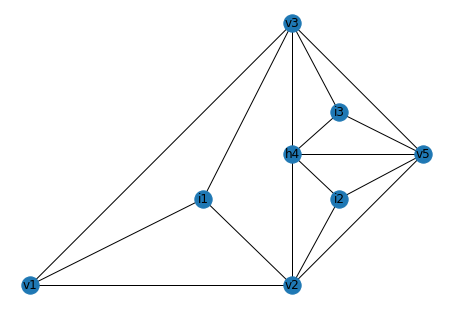

In [210]:
G = nx.Graph()
    
vertices = {"v1": (0, 0, 0),  
            "v2": (100, 0, 0), 
            "v3": (100, 100, 0),
            "h4": (100, 50, 0),
            "v5": (150, 50, 0),
            "i1": (66, 33, 0),
            "i2": (118, 33, 0),
            "i3": (118, 66, 0)}
                
for n, c in vertices.items():
    G.add_node(n, x=c[0], y=c[1], z=c[2])
    
attrs = {"i1": {'R': True}, "i2": {'R': True}, "i3": {'R': True}}
nx.set_node_attributes(G, attrs)

G.add_edge("v1", "v2", length = 100, B=True)
G.add_edge("v3", "v1", length = 141.4, B=True)
G.add_edge("v2", "h4", length = 50, B=False)
G.add_edge("h4", "v3", length = 50, B=False)
G.add_edge("v2", "v5", length = 22.36, B=True)
G.add_edge("v3", "v5", length = 22.36, B=True)
G.add_edge("h4", "v5", length = 50, B=False)

G.add_edge("i1", "v1")
G.add_edge("i1", "v2")
G.add_edge("i1", "v3")

G.add_edge("i2", "v2")
G.add_edge("i2", "h4")
G.add_edge("i2", "v5")

G.add_edge("i3", "v3")
G.add_edge("i3", "h4")
G.add_edge("i3", "v5")

nx.draw(G, build_pos_dict(G), with_labels = True)
plt.show()

1:  100


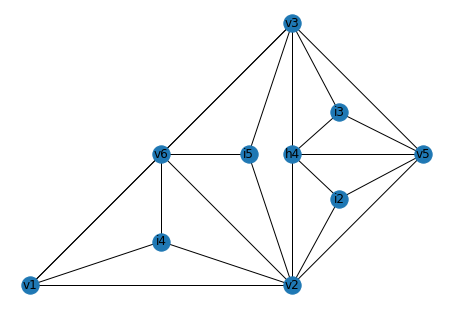

In [211]:
transform_P5(G, "i1")
nx.draw(G, build_pos_dict(G), with_labels = True)
plt.show()

# P6

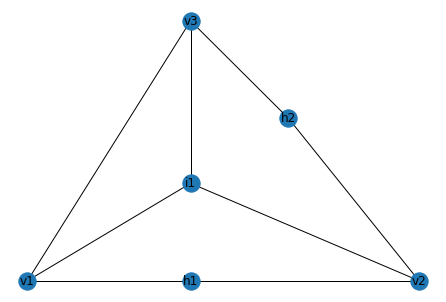

In [14]:
def get_valid_P6_graph():
    G = nx.Graph()
    vertices = {"v1": (0, 0, 0), 
                "h1": (5, 0, 0), 
                "v2": (12, 0, 0), 
                "h2": (8, 5, 0),
                "v3": (5, 8, 0),
                "i1": (5,3,0)
               }
                
    for n, c in vertices.items():
        G.add_node(n, x=c[0], y=c[1], z=c[2])

    attrs = {"i1": {'R': True}, 
             "i2": {'R': False}, 
             "i3": {'R': False}}
    nx.set_node_attributes(G, attrs)

    G.add_edge("v1", "h1", length = 5, B=False)
    G.add_edge("v2", "h1", length = 7, B=False)
    G.add_edge("v2", "h2", length = 6.4, B=False)
    G.add_edge("v3", "h2", length = 4.2, B=False)
    G.add_edge("v3", "v1", length = 11, B=False)
    G.add_edge("i1", "v1", B=False)
    G.add_edge("i1", "v2", B=False)
    G.add_edge("i1", "v3", B=False)
    
    return G

G = get_valid_P6_graph()
nx.draw(G, build_pos_dict(G), with_labels = True)

In [15]:
i = "i1"
G = get_test_graph()
check = is_P6_possible(G, i)
if check: 
    G = transform_P6(G, i)
    nx.draw(G, build_pos_dict(G), with_labels = True)
else:
    print("P6 not possible on this graph for " + i)

NameError: name 'is_P6_possible' is not defined

In [ ]:
i = "i1"
G = get_valid_P6_graph()
check = is_P6_possible(G, i)
if check: 
    G = transform_P6(G, i)
    nx.draw(G, build_pos_dict(G), with_labels = True)
else:
    print("P6 not possible on this graph for " + i)

In [ ]:
# Graf podany na zajęciach na którym sprawdzana była poprawność rozwiązania
def get_P6_test_graph():
    G = nx.Graph()
    vertices = {"v1": (0, 0, 0), 
                "v2": (100, 0, 0), 
                "v3": (0, 100, 0),
                "v4": (100, 100, 0),
                "v5": (150, 50, 0), 
                "h1": (50, 50, 0),
                "h2": (100, 50, 0),
                "i1": (50, 20, 0),
                "i2": (20, 50, 0),
                "i3": (75, 60, 0),
                "i4": (115, 40, 0),
                "i5": (115, 70, 0)
               }
    
    for n, c in vertices.items():
        G.add_node(n, x=c[0], y=c[1], z=c[2])

    attrs = {"i1": {'R': True}, 
             "i2": {'R': False}, 
             "i3": {'R': False},
             "i4": {'R': False},
             "i5": {'R': False}
            }
    nx.set_node_attributes(G, attrs)
    
    G.add_edge("v1", "v2", length = 100, B=False)
    G.add_edge("v1", "v3", length = 100, B=False)
    G.add_edge("v3", "v4", length = 100, B=False)  
    
    G.add_edge("v1", "h1", length = 70.7, B=False)
    G.add_edge("v2", "h1", length = 70.7, B=False)   
    G.add_edge("v3", "h1", length = 70.7, B=False)   

    G.add_edge("v2", "h2", length = 50, B=False)
    G.add_edge("v4", "h2", length = 50, B=False)
    
    G.add_edge("v5", "h2", length = 50, B=False)
    
    G.add_edge("v2", "v5", length = 35.4, B=False)
    G.add_edge("v4", "v5", length = 35.4, B=False)
    
    
    G.add_edge("i1", "v1", length = 35.4, B=False)
    G.add_edge("i1", "v2", length = 35.4, B=False)
    G.add_edge("i1", "h1", length = 35.4, B=False)
    
    G.add_edge("i2", "v1", length = 35.4, B=False)
    G.add_edge("i2", "v3", length = 35.4, B=False)
    G.add_edge("i2", "h1", length = 35.4, B=False)
    
    
    G.add_edge("i3", "v2", length = 35.4, B=False)
    G.add_edge("i3", "v3", length = 35.4, B=False)
    G.add_edge("i3", "v4", length = 35.4, B=False)
    
    
    G.add_edge("i4", "v2", length = 35.4, B=False)
    G.add_edge("i4", "v5", length = 35.4, B=False)
    G.add_edge("i4", "h2", length = 35.4, B=False)
    
    
    G.add_edge("i5", "v4", length = 35.4, B=False)
    G.add_edge("i5", "v5", length = 35.4, B=False)
    G.add_edge("i5", "h2", length = 35.4, B=False)
    
    
    return G

G = get_P6_test_graph()
nx.draw(G, build_pos_dict(G), with_labels = True)    

In [ ]:
# Test w odwróconej orientacji
def get_P6_test_graph_reversed():
    G = nx.Graph()
    vertices = {"v1": (0, 0, 0), 
                "v2": (-100, 0, 0), 
                "v3": (0, 100, 0),
                "v4": (-100, 100, 0),
                "v5": (-150, 50, 0), 
                "h1": (-50, 50, 0),
                "h2": (-100, 50, 0),
                "i1": (-50, 20, 0),
                "i2": (-20, 50, 0),
                "i3": (-75, 60, 0),
                "i4": (-115, 40, 0),
                "i5": (-115, 70, 0)
               }
    
    for n, c in vertices.items():
        G.add_node(n, x=c[0], y=c[1], z=c[2])

    attrs = {"i1": {'R': True}, 
             "i2": {'R': False}, 
             "i3": {'R': False},
             "i4": {'R': False},
             "i5": {'R': False}
            }
    nx.set_node_attributes(G, attrs)
    
    G.add_edge("v1", "v2", length = 100, B=False)
    G.add_edge("v1", "v3", length = 100, B=False)
    G.add_edge("v3", "v4", length = 100, B=False)  
    
    G.add_edge("v1", "h1", length = 70.7, B=False)
    G.add_edge("v2", "h1", length = 70.7, B=False)   
    G.add_edge("v3", "h1", length = 70.7, B=False)   

    G.add_edge("v2", "h2", length = 25, B=False)
    G.add_edge("v4", "h2", length = 25, B=False)
    
    G.add_edge("v5", "h2", length = 50, B=False)
    
    G.add_edge("v2", "v5", length = 35.4, B=False)
    G.add_edge("v4", "v5", length = 35.4, B=False)
    
    
    G.add_edge("i1", "v1", length = 35.4, B=False)
    G.add_edge("i1", "v2", length = 35.4, B=False)
    G.add_edge("i1", "h1", length = 35.4, B=False)
    
    G.add_edge("i2", "v1", length = 35.4, B=False)
    G.add_edge("i2", "v3", length = 35.4, B=False)
    G.add_edge("i2", "h1", length = 35.4, B=False)
    
    
    G.add_edge("i3", "v2", length = 35.4, B=False)
    G.add_edge("i3", "v3", length = 35.4, B=False)
    G.add_edge("i3", "v4", length = 35.4, B=False)
    
    
    G.add_edge("i4", "v2", length = 35.4, B=False)
    G.add_edge("i4", "v5", length = 35.4, B=False)
    G.add_edge("i4", "h2", length = 35.4, B=False)
    
    
    G.add_edge("i5", "v4", length = 35.4, B=False)
    G.add_edge("i5", "v5", length = 35.4, B=False)
    G.add_edge("i5", "h2", length = 35.4, B=False)
    
    
    return G

G = get_P6_test_graph_reversed()
nx.draw(G, build_pos_dict(G), with_labels = True)    

In [ ]:
i = "i3"
G = get_P6_test_graph()
check = is_P6_possible(G, i)
if check: 
    G = transform_P6(G, i)
    nx.draw(G, build_pos_dict(G), with_labels = True)
else:
    print("P6 not possible on this graph for " + i)

In [ ]:
i = "i3"
G = get_P6_test_graph_reversed()
check = is_P6_possible(G, i)
if check: 
    G = transform_P6(G, i)
    nx.draw(G, build_pos_dict(G), with_labels = True)
else:
    print("P6 not possible on this graph for " + i)

In [ ]:
def get_graph_layout_P6(G, i):
    h = None
    v1 = None
    v2 = None
    v3 = None
    
    edges = {}
    longest_edge_sum = 0
    edge_without_hanging_node=None
    not_vs = ()
      
    for vi,vj in combinations(list(G.neighbors(i)),2):
        key = (vi,vj)
        if vi.startswith('h') or vj.startswith('h'):
            return (edges, v1, v2, v3, h);
        edges[key] = []
        if (vi in list(G.neighbors(vj))) and (vj in list(G.neighbors(vi))):
            if len(edges[key])==0:
                edges[key].append(G.edges[vi, vj])
                edge_without_hanging_node = edges[key][0]
            else:
                return (None, None, None, None)
        else:
            if any(t.startswith('h') for t in sorted(nx.common_neighbors(G, vi, vj))):
                h_node=next((x for x in sorted(nx.common_neighbors(G, vi, vj)) if x.startswith('h')), None)
                edges[key].append(G.edges[vi,h_node])
                edges[key].append(G.edges[vj,h_node])
                length = G.edges[vi,h_node]['length'] + G.edges[vj,h_node]['length']
                if (length > longest_edge_sum):
                    longest_edge_sum = length
                    h = h_node
                    not_vs = (vi,vj)
    
    counter = 0
    for k,v in edges.items():
        if len(v)==2:
            counter=counter+1
    if counter != 2:
        return (None, None, None, None, None)
    
    v3 = [v for v in list(G.neighbors(i)) if v not in not_vs][0]
    if len(not_vs)!=0:
        if any(t.startswith('h') for t in sorted(nx.common_neighbors(G, v3, not_vs[0]))):
            v1 = not_vs[1]
            v2 = not_vs[0]
        else:
            v1 = not_vs[0]
            v2 = not_vs[1]

    return (edges, v1, v2, v3, h)

In [ ]:
def is_P6_possible(G, i):
    if len(list(G.neighbors(i)))!=3:
        return False
    else:    
        (edges, v1, v2, v3, h) = get_graph_layout_P6(G,i)
        pp.pprint(edges)
        print(v1, v2, v3, h)
        if not v3: return False
    
    if is_condition_P6_fulfilled(edges, v3): 
        return True
    else: return False
    
    
def is_condition_P6_fulfilled(edges, v3):
    l1=l2=l3=l4=l5=0
    
    for (vi,vj), edge in edges.items():
        if v3 not in (vi,vj):
            l1 = edge[0]['length']
            l2 = edge[1]['length']
        elif len(edge)==1:
            l5 = edge[0]['length']
        else:
            l3 = edge[0]['length']
            l4 = edge[1]['length']
    
    if ((l1+l2) >= l3+l4) and ((l1+l2)>=l5):
        print('Condition P6 passed')
        return True
    else:
        print('Condition P6 failed')
        return False

In [ ]:
def transform_P6(G, i_node):
    (edges, v1, v2, v3, h_node) = get_graph_layout_P6(G,i)
   
    # zmiana h_node na normalny node z tymi samymi współrzędnymi
    last_v_index = next((x for x in sorted(list(G.nodes),reverse=True ) if x.startswith('v')), None)
    current_number = int(last_v_index[1:]) + 1
    new_v_node = "v" + str(current_number)
        
    x1 = G.nodes[h_node]['x']
    y1 = G.nodes[h_node]['y']
    z1 = G.nodes[h_node]['z']
    
    mapping={h_node: new_v_node}
    G=nx.relabel_nodes(G,mapping)
    
    #krawędź:
    l6 = math.sqrt(math.pow(x1 - G.nodes[v3]['x'], 2) + math.pow(y1 - G.nodes[v3]['y'], 2) \
                   + math.pow(z1 - G.nodes[v3]['z'], 2))
    G.add_edge(v3, new_v_node, B = False, length = l6)

    #nowy punkt i1:
    last_i_index = next((x for x in sorted(list(G.nodes),reverse=True ) if x.startswith('i')), None)
    current_number = int(last_i_index[1:]) + 1
    new_i_node = "i" + str(current_number)
    x_i1 = (G.node[new_v_node]['x'])/3 + (G.node[v1]['x'])/3 + (G.node[v3]['x'])/3
    y_i1 = (G.node[new_v_node]['y'])/3 + (G.node[v1]['y'])/3 + (G.node[v3]['y'])/3
    z_i1 = (G.node[new_v_node]['z'])/3 + (G.node[v1]['z'])/3 + (G.node[v3]['z'])/3 
    G.add_node(new_i_node, x=x_i1, y=y_i1, z=z_i1)
    
    G.add_edge(new_i_node, v1)
    G.add_edge(new_i_node, v3)
    G.add_edge(new_i_node, new_v_node)
    
    #nowy punkt i2:
    last_i_index = next((x for x in sorted(list(G.nodes),reverse=True ) if x.startswith('i')), None)
    current_number = int(last_i_index[1:]) + 1
    new_i_node = "i" + str(current_number)
    x_i2 = (G.node[new_v_node]['x'])/3 + (G.node[v2]['x'])/3 + (G.node[v3]['x'])/3
    y_i2 = (G.node[new_v_node]['y'])/3 + (G.node[v2]['y'])/3 + (G.node[v3]['y'])/3
    z_i2 = (G.node[new_v_node]['z'])/3 + (G.node[v2]['z'])/3 + (G.node[v3]['z'])/3 
    G.add_node(new_i_node, x=x_i2, y=y_i2, z=z_i2)
      
    G.add_edge(new_i_node, v3)
    G.add_edge(new_i_node, v2)
    G.add_edge(new_i_node, new_v_node)

    attrs = {
        "i2": {'R': False}, 
        "i3": {'R': False}}
    nx.set_node_attributes(G, attrs)
        
    G.remove_node(i)

    return G

# P7

In [195]:
def transform_p7(G, i):
    # Jak i nie ma trzech sąsiadów to od razu wracamy
    if len(list(G.neighbors(i)))!=3:
        return False
    # będziemy szukać krawędzi która nie ma hanging node
    # to nam zoritentuje graf
    else:
        v1 = list(G.neighbors(i))[0]
        v2 = list(G.neighbors(i))[1]
        v3 = list(G.neighbors(i))[2]
        e1 = []
        e2 = []
        e3 = []
        edge_without_hanging_node=None
        
        #szukam krawędzi między v1 i v2
        if (v1 in list(G.neighbors(v2))) and (v2 in list(G.neighbors(v1))):
            e1 = G.edges[v1, v2]
            edge_without_hanging_node = e1
        else:
            if any(t.startswith('h') for t in sorted(nx.common_neighbors(G, v1, v2))):
                h_edge=next((x for x in sorted(nx.common_neighbors(G, v1, v2)) if x.startswith('h')), None)
                e1.append(G.edges[v1,h_edge])
                e1.append(G.edges[v2,h_edge])
            else:
                return False
          
        # między v2 i v3
        if (v2 in list(G.neighbors(v3))) and (v3 in list(G.neighbors(v2))):
            e2 = G.edges[v2, v3]
            if edge_without_hanging_node == None:
                edge_without_hanging_node = e2
            else:
                return False
        else:
            if any(t.startswith('h') for t in sorted(nx.common_neighbors(G, v2, v3))):
                h_edge=next((x for x in sorted(nx.common_neighbors(G, v2, v3)) if x.startswith('h')), None)
                e2.append(G.edges[v2,h_edge])
                e2.append(G.edges[v3,h_edge])
            else:
                return False
            
        # między v3 i v1    
        if (v1 in list(G.neighbors(v3))) and (v3 in list(G.neighbors(v1))):
            e3 = G.edges[v1, v3]
            if edge_without_hanging_node == None:
                edge_without_hanging_node = e3
            else:
                return False
        else:
            if any(t.startswith('h') for t in sorted(nx.common_neighbors(G, v1, v3))):
                h_edge=next((x for x in sorted(nx.common_neighbors(G, v1, v3)) if x.startswith('h')), None)
                e3.append(G.edges[v1,h_edge])
                e3.append(G.edges[v3,h_edge])
            else:
                return False
    print (e1)
    print (e2)
    print (e3)
    print (edge_without_hanging_node)
    
    
    # sprawdzenie zadanego warunku:
    if (e1==edge_without_hanging_node) and (edge_without_hanging_node['length'])<=(e2[0]['length'])+(e2[1]['length']) and (edge_without_hanging_node['length'])<=(e3[0]['length'])+(e3[1]['length']):
        return False
    if (e2==edge_without_hanging_node) and (edge_without_hanging_node['length'])<=(e1[0]['length'])+(e1[1]['length']) and (edge_without_hanging_node['length'])<=(e3[0]['length'])+(e3[1]['length']):
        return False
    if (e3==edge_without_hanging_node) and (edge_without_hanging_node['length'])<=(e2[0]['length'])+(e2[1]['length']) and (edge_without_hanging_node['length'])<=(e1[0]['length'])+(e1[1]['length']):
        return False
    
    # usuwam punkt I
    # usunięcie node'a od razu pociąga za sobą usunięcie jego krawędzi
    G.remove_node(i)
    
    #nowy punkt V:
    last_v_index = next((x for x in sorted(list(G.nodes),reverse=True ) if x.startswith('v')), None)
    current_number = int(last_v_index[1:]) + 1
    new_v_node = "h" + str(current_number)
    print ("nowy punkt v będzie się nazywał: " + new_v_node)
    G.add_node(new_v_node)
    
    #nowe punkty I:
    last_i_index = next((x for x in sorted(list(G.nodes),reverse=True ) if x.startswith('i')), None)
    current_number = int(last_i_index[1:]) + 1
    new_i_node = "i" + str(current_number)
    print ("nowy punkt i będzie się nazywał: " + new_i_node)
    
    last_i_index = next((x for x in sorted(list(G.nodes),reverse=True ) if x.startswith('i')), None)
    current_number = int(last_i_index[1:]) + 2
    new_i_node2 = "i" + str(current_number)
    print ("nowy punkt i będzie się nazywał: " + new_i_node2)
    
    
    if (e1==edge_without_hanging_node):
        print ("nowy wierzcholek ma byc miedzy v1 a v2")
        l2 = 30 #nx.get_edge_attributes(G,'length')[(v1,v2)]
        G.remove_edge(v1, v2)
        
        new_x = (G.node[v1]['x']/2) + (G.node[v2]['x']/2)
        new_y = (G.node[v1]['y']/2) + (G.node[v2]['y']/2)
        new_z = (G.node[v1]['z']/2) + (G.node[v2]['z']/2)
        
        # dodajemy nowy node
        G.add_node(new_v_node, x=new_x, y=new_y, z=new_z);
        
        # nowe edże
        G.add_edge(v1, new_v_node, length = l2/2)
        G.add_edge(v2, new_v_node, length = l2/2)
        
        # add new_i1 positions
        new_x_for_i = (G.node[new_v_node]['x'])/3 + (G.node[v2]['x'])/3 + (G.node[v3]['x'])/3
        new_y_for_i = (G.node[new_v_node]['y'])/3 + (G.node[v2]['y'])/3 + (G.node[v3]['y'])/3
        new_z_for_i = (G.node[new_v_node]['z'])/3 + (G.node[v2]['z'])/3 + (G.node[v3]['z'])/3                                                                       
        G.add_node(new_i_node, x=new_x_for_i, y=new_y_for_i, z=new_z_for_i); 
        attrs[new_i_node] = {'R': False}
        G.add_edge(new_v_node, new_i_node)
        G.add_edge(v2, new_i_node)
        G.add_edge(v3, new_i_node)
        
        # add new_i2 positions
        new_x_for_i2 = 34 #(G.node[new_v_node]['x'])/3 + (G.node[v2]['x'])/3 + (G.node[v1]['x'])/3
        new_y_for_i2 = 10 #(G.node[new_v_node]['y'])/3 + (G.node[v2]['y'])/3 + (G.node[v1]['y'])/3
        new_z_for_i2 = (G.node[new_v_node]['z'])/3 + (G.node[v2]['z'])/3 + (G.node[v1]['z'])/3
        G.add_node(new_i_node2, x=new_x_for_i2, y=new_y_for_i2, z=new_z_for_i2);
        attrs[new_i_node2] = {'R': False}
        G.add_edge(new_v_node, new_i_node2)
        G.add_edge(v1, new_i_node2)
        G.add_edge(v3, new_i_node2)
    
        last_edge_length=math.sqrt(math.pow(G.node[v3]['x'] - new_x, 2) + math.pow(G.node[v3]['y'] - new_y, 2))
        G.add_edge(new_v_node, v3)
        
    elif (e2==edge_without_hanging_node):
        print ("nowy wierzcholek ma byc miedzy v2 a v3")
        l2 = nx.get_edge_attributes(G,'length')[(v3,v2)]
        G.remove_edge(v2, v3)
        
        new_x = (G.node[v3]['x']/2) + (G.node[v2]['x']/2)
        new_y = (G.node[v3]['y']/2) + (G.node[v2]['y']/2)
        new_z = (G.node[v3]['z']/2) + (G.node[v2]['z']/2)
        
        # dodajemy nowy node
        G.add_node(new_v_node, x=new_x, y=new_y, z=new_z);
        
        # nowe edże
        G.add_edge(v2, new_v_node, length = l2/2)
        G.add_edge(v3, new_v_node, length = l2/2)
        
        #add new i1 positions
        new_x_for_i = (G.node[new_v_node]['x'])/3 + (G.node[v3]['x'])/3 + (G.node[v1]['x'])/3
        new_y_for_i = (G.node[new_v_node]['y'])/3 + (G.node[v3]['y'])/3 + (G.node[v1]['y'])/3
        new_z_for_i = (G.node[new_v_node]['z'])/3 + (G.node[v3]['z'])/3 + (G.node[v1]['z'])/3
        G.add_node(new_i_node, x=new_x_for_i, y=new_y_for_i, z=new_z_for_i);  
        attrs[new_i_node] = {'R': False}
        G.add_edge(new_v_node, new_i_node)
        G.add_edge(v3, new_i_node)
        G.add_edge(v2, new_i_node)
        
        new_x_for_i2 = (G.node[new_v_node]['x'])/3 + (G.node[v2]['x'])/3 + (G.node[v1]['x'])/3
        new_y_for_i2 = (G.node[new_v_node]['y'])/3 + (G.node[v2]['y'])/3 + (G.node[v1]['y'])/3
        new_z_for_i2 = (G.node[new_v_node]['z'])/3 + (G.node[v2]['z'])/3 + (G.node[v1]['z'])/3
        G.add_node(new_i_node2, x=new_x_for_i2, y=new_y_for_i2, z=new_z_for_i2);
        attrs[new_i_node2] = {'R': False}
        G.add_edge(new_v_node, new_i_node2)
        G.add_edge(v1, new_i_node2)
        G.add_edge(v2, new_i_node2)
        
        last_edge_length=math.sqrt(math.pow(G.node[v1]['x'] - new_x, 2) + math.pow(G.node[v1]['y'] - new_y, 2))
        G.add_edge(new_v_node, v1, length=last_edge_length)
        
    elif (e3==edge_without_hanging_node):
        print("nowy wierzcholek ma byc miedzy v1 a v3")
        l2 = nx.get_edge_attributes(G,'length')[(v1,v3)]
        G.remove_edge(v1, v3)
        
        new_x = (G.node[v1]['x']/2) + (G.node[v3]['x']/2)
        new_y = (G.node[v1]['y']/2) + (G.node[v3]['y']/2)
        new_z = (G.node[v1]['z']/2) + (G.node[v3]['z']/2)
        
        # dodajemy nowy node
        G.add_node(new_v_node, x=new_x, y=new_y, z=new_z);
        
        # nowe edże
        G.add_edge(v1, new_v_node, length = l2/2)
        G.add_edge(v3, new_v_node, length = l2/2)
        
        # add new_i1 positions
        new_x_for_i = (G.node[new_v_node]['x'])/3 + (G.node[v3]['x'])/3 + (G.node[v2]['x'])/3
        new_y_for_i = (G.node[new_v_node]['y'])/3 + (G.node[v3]['y'])/3 + (G.node[v2]['y'])/3
        new_z_for_i = (G.node[new_v_node]['z'])/3 + (G.node[v3]['z'])/3 + (G.node[v2]['z'])/3                                                                       
        G.add_node(new_i_node, x=new_x_for_i, y=new_y_for_i, z=new_z_for_i);                                                                          
        attrs[new_i_node] = {'R': False}                                                                          
        G.add_edge(new_v_node, new_i_node)
        G.add_edge(v3, new_i_node)
        G.add_edge(v2, new_i_node)
        
        new_x_for_i2 = (G.node[new_v_node]['x'])/3 + (G.node[v2]['x'])/3 + (G.node[v1]['x'])/3
        new_y_for_i2 = (G.node[new_v_node]['y'])/3 + (G.node[v2]['y'])/3 + (G.node[v1]['y'])/3
        new_z_for_i2 = (G.node[new_v_node]['z'])/3 + (G.node[v2]['z'])/3 + (G.node[v1]['z'])/3
        G.add_node(new_i_node2, x=new_x_for_i2, y=new_y_for_i2, z=new_z_for_i2);
        attrs[new_i_node2] = {'R': False}
        G.add_edge(new_v_node, new_i_node2)
        G.add_edge(v1, new_i_node2)
        G.add_edge(v2, new_i_node2)
        
        last_edge_length=math.sqrt(math.pow(G.node[v2]['x'] - new_x, 2) + math.pow(G.node[v2]['y'] - new_y, 2))
        G.add_edge(new_v_node, v2, length=last_edge_length)
        
    nx.set_node_attributes(G, attrs)
    nx.draw(G, build_pos_dict(G), with_labels = True)
    return True
    

In [ ]:
G = get_test_graph()
print(find_graph_P7(G, "i1"))

# P8

In [ ]:
def find_graph_P8(G, i):
    # Jak i nie ma trzech sąsiadów to od razu wracamy
    if len(list(G.neighbors(i)))!=3:
        return False
    # będziemy szukać krawędzi która nie ma hanging node
    # to nam zoritentuje graf
    else:
        v1 = list(G.neighbors(i))[0]
        v2 = list(G.neighbors(i))[1]
        v3 = list(G.neighbors(i))[2]
        e1 = []
        e2 = []
        e3 = []
        edge_without_hanging_node=None
        
        #szukam krawędzi między v1 i v2
        if (v1 in list(G.neighbors(v2))) and (v2 in list(G.neighbors(v1))):
            e1 = G.edges[v1, v2]
            edge_without_hanging_node = e1
        else:
            if any(t.startswith('h') for t in sorted(nx.common_neighbors(G, v1, v2))):
                h_edge=next((x for x in sorted(nx.common_neighbors(G, v1, v2)) if x.startswith('h')), None)
                e1.append(G.edges[v1,h_edge])
                e1.append(G.edges[v2,h_edge])
            else:
                return False
          
        # między v2 i v3
        if (v2 in list(G.neighbors(v3))) and (v3 in list(G.neighbors(v2))):
            e2 = G.edges[v2, v3]
            if edge_without_hanging_node == None:
                edge_without_hanging_node = e2
            else:
                return False
        else:
            if any(t.startswith('h') for t in sorted(nx.common_neighbors(G, v2, v3))):
                h_edge=next((x for x in sorted(nx.common_neighbors(G, v2, v3)) if x.startswith('h')), None)
                e2.append(G.edges[v2,h_edge])
                e2.append(G.edges[v3,h_edge])
            else:
                return False
            
        # między v3 i v1    
        if (v1 in list(G.neighbors(v3))) and (v3 in list(G.neighbors(v1))):
            e3 = G.edges[v1, v3]
            if edge_without_hanging_node == None:
                edge_without_hanging_node = e3
            else:
                return False
        else:
            if any(t.startswith('h') for t in sorted(nx.common_neighbors(G, v1, v3))):
                h_edge=next((x for x in sorted(nx.common_neighbors(G, v1, v3)) if x.startswith('h')), None)
                e3.append(G.edges[v1,h_edge])
                e3.append(G.edges[v3,h_edge])
            else:
                return False
    print (e1)
    print (e2)
    print (e3)
    print (edge_without_hanging_node)
    
    
    # sprawdzenie zadanego warunku:
    if (e1==edge_without_hanging_node) and (edge_without_hanging_node['length'])<=(e2[0]['length'])+(e2[1]['length']) and (edge_without_hanging_node['length'])<=(e3[0]['length'])+(e3[1]['length']):
        return False
    if (e2==edge_without_hanging_node) and (edge_without_hanging_node['length'])<=(e1[0]['length'])+(e1[1]['length']) and (edge_without_hanging_node['length'])<=(e3[0]['length'])+(e3[1]['length']):
        return False
    if (e3==edge_without_hanging_node) and (edge_without_hanging_node['length'])<=(e2[0]['length'])+(e2[1]['length']) and (edge_without_hanging_node['length'])<=(e1[0]['length'])+(e1[1]['length']):
        return False
    
    # usuwam punkt I
    # usunięcie node'a od razu pociąga za sobą usunięcie jego krawędzi
    G.remove_node(i)
    
    #nowy punkt H:
    last_h_index = next((x for x in sorted(list(G.nodes),reverse=True ) if x.startswith('h')), None)
    current_number = int(last_h_index[1:]) + 1
    new_h_node = "h" + str(current_number)
    print ("nowy punkt h będzie się nazywał: " + new_h_node)
    G.add_node(new_h_node)
    
    #nowe punkty I:
    last_i_index = next((x for x in sorted(list(G.nodes),reverse=True ) if x.startswith('i')), None)
    current_number = int(last_i_index[1:]) + 1
    new_i_node = "i" + str(current_number)
    print ("nowy punkt i będzie się nazywał: " + new_i_node)
    
    last_i_index = next((x for x in sorted(list(G.nodes),reverse=True ) if x.startswith('i')), None)
    current_number = int(last_i_index[1:]) + 2
    new_i_node2 = "i" + str(current_number)
    print ("nowy punkt i będzie się nazywał: " + new_i_node2)
    
    
    if (e1==edge_without_hanging_node):
        print ("nowy wierzcholek ma byc miedzy v1 a v2")
        l2 = nx.get_edge_attributes(G,'length')[(v1,v2)]
        G.remove_edge(v1, v2)
        
        new_x = (G.node[v1]['x']/2) + (G.node[v2]['x']/2)
        new_y = (G.node[v1]['y']/2) + (G.node[v2]['y']/2)
        new_z = (G.node[v1]['z']/2) + (G.node[v2]['z']/2)
        
        # dodajemy nowy node
        G.add_node(new_h_node, x=new_x, y=new_y, z=new_z);
        
        # nowe edge
        G.add_edge(v1, new_h_node, length = l2/2)
        G.add_edge(v2, new_h_node, length = l2/2)
        
        # add new_i1 positions
        new_x_for_i = (G.node[new_h_node]['x'])/3 + (G.node[v2]['x'])/3 + (G.node[v3]['x'])/3
        new_y_for_i = (G.node[new_h_node]['y'])/3 + (G.node[v2]['y'])/3 + (G.node[v3]['y'])/3
        new_z_for_i = (G.node[new_h_node]['z'])/3 + (G.node[v2]['z'])/3 + (G.node[v3]['z'])/3                                                                       
        G.add_node(new_i_node, x=new_x_for_i, y=new_y_for_i, z=new_z_for_i); 
        attrs[new_i_node] = {'R': False}
        G.add_edge(new_h_node, new_i_node)
        G.add_edge(v2, new_i_node)
        G.add_edge(v3, new_i_node)
        
        # add new_i2 positions
        new_x_for_i2 = (G.node[new_h_node]['x'])/3 + (G.node[v2]['x'])/3 + (G.node[v1]['x'])/3
        new_y_for_i2 = (G.node[new_h_node]['y'])/3 + (G.node[v2]['y'])/3 + (G.node[v1]['y'])/3
        new_z_for_i2 = (G.node[new_h_node]['z'])/3 + (G.node[v2]['z'])/3 + (G.node[v1]['z'])/3
        G.add_node(new_i_node2, x=new_x_for_i2, y=new_y_for_i2, z=new_z_for_i2);
        attrs[new_i_node2] = {'R': False}
        G.add_edge(new_h_node, new_i_node2)
        G.add_edge(v1, new_i_node2)
        G.add_edge(v3, new_i_node2)
    
        last_edge_length=math.sqrt(math.pow(G.node[v3]['x'] - new_x, 2) + math.pow(G.node[v3]['y'] - new_y, 2))
        G.add_edge(new_h_node, v3)
        
    elif (e2==edge_without_hanging_node):
        print ("nowy wierzcholek ma byc miedzy v2 a v3")
        l2 = nx.get_edge_attributes(G,'length')[(v3,v2)]
        G.remove_edge(v2, v3)
        
        new_x = (G.node[v3]['x']/2) + (G.node[v2]['x']/2)
        new_y = (G.node[v3]['y']/2) + (G.node[v2]['y']/2)
        new_z = (G.node[v3]['z']/2) + (G.node[v2]['z']/2)
        
        # dodajemy nowy node
        G.add_node(new_h_node, x=new_x, y=new_y, z=new_z);
        
        # nowe edże
        G.add_edge(v2, new_h_node, length = l2/2)
        G.add_edge(v3, new_h_node, length = l2/2)
        
        #add new i1 positions
        new_x_for_i = (G.node[new_h_node]['x'])/3 + (G.node[v3]['x'])/3 + (G.node[v1]['x'])/3
        new_y_for_i = (G.node[new_h_node]['y'])/3 + (G.node[v3]['y'])/3 + (G.node[v1]['y'])/3
        new_z_for_i = (G.node[new_h_node]['z'])/3 + (G.node[v3]['z'])/3 + (G.node[v1]['z'])/3
        G.add_node(new_i_node, x=new_x_for_i, y=new_y_for_i, z=new_z_for_i);  
        attrs[new_i_node] = {'R': False}
        G.add_edge(new_h_node, new_i_node)
        G.add_edge(v3, new_i_node)
        G.add_edge(v2, new_i_node)
        
        new_x_for_i2 = (G.node[new_h_node]['x'])/3 + (G.node[v2]['x'])/3 + (G.node[v1]['x'])/3
        new_y_for_i2 = (G.node[new_h_node]['y'])/3 + (G.node[v2]['y'])/3 + (G.node[v1]['y'])/3
        new_z_for_i2 = (G.node[new_h_node]['z'])/3 + (G.node[v2]['z'])/3 + (G.node[v1]['z'])/3
        G.add_node(new_i_node2, x=new_x_for_i2, y=new_y_for_i2, z=new_z_for_i2);
        attrs[new_i_node2] = {'R': False}
        G.add_edge(new_h_node, new_i_node2)
        G.add_edge(v1, new_i_node2)
        G.add_edge(v2, new_i_node2)
        
        last_edge_length=math.sqrt(math.pow(G.node[v1]['x'] - new_x, 2) + math.pow(G.node[v1]['y'] - new_y, 2))
        G.add_edge(new_h_node, v1, length=last_edge_length)
        
    elif (e3==edge_without_hanging_node):
        print("nowy wierzcholek ma byc miedzy v1 a v3")
        l2 = nx.get_edge_attributes(G,'length')[(v1,v3)]
        G.remove_edge(v1, v3)
        
        new_x = (G.node[v1]['x']/2) + (G.node[v3]['x']/2)
        new_y = (G.node[v1]['y']/2) + (G.node[v3]['y']/2)
        new_z = (G.node[v1]['z']/2) + (G.node[v3]['z']/2)
        
        # dodajemy nowy node
        G.add_node(new_h_node, x=new_x, y=new_y, z=new_z);
        
        # nowe edże
        G.add_edge(v1, new_h_node, length = l2/2)
        G.add_edge(v3, new_h_node, length = l2/2)
        
        # add new_i1 positions
        new_x_for_i = (G.node[new_h_node]['x'])/3 + (G.node[v3]['x'])/3 + (G.node[v2]['x'])/3
        new_y_for_i = (G.node[new_h_node]['y'])/3 + (G.node[v3]['y'])/3 + (G.node[v2]['y'])/3
        new_z_for_i = (G.node[new_h_node]['z'])/3 + (G.node[v3]['z'])/3 + (G.node[v2]['z'])/3                                                                       
        G.add_node(new_i_node, x=new_x_for_i, y=new_y_for_i, z=new_z_for_i);                                                                          
        attrs[new_i_node] = {'R': False}                                                                          
        G.add_edge(new_h_node, new_i_node)
        G.add_edge(v3, new_i_node)
        G.add_edge(v2, new_i_node)
        
        new_x_for_i2 = (G.node[new_h_node]['x'])/3 + (G.node[v2]['x'])/3 + (G.node[v1]['x'])/3
        new_y_for_i2 = (G.node[new_h_node]['y'])/3 + (G.node[v2]['y'])/3 + (G.node[v1]['y'])/3
        new_z_for_i2 = (G.node[new_h_node]['z'])/3 + (G.node[v2]['z'])/3 + (G.node[v1]['z'])/3
        G.add_node(new_i_node2, x=new_x_for_i2, y=new_y_for_i2, z=new_z_for_i2);
        attrs[new_i_node2] = {'R': False}
        G.add_edge(new_h_node, new_i_node2)
        G.add_edge(v1, new_i_node2)
        G.add_edge(v2, new_i_node2)
        
        last_edge_length=math.sqrt(math.pow(G.node[v2]['x'] - new_x, 2) + math.pow(G.node[v2]['y'] - new_y, 2))
        G.add_edge(new_h_node, v2, length=last_edge_length)
        
    nx.set_node_attributes(G, attrs)
    nx.draw(G, build_pos_dict(G), with_labels = True)
    return True

In [ ]:
G = get_test_graph()
print(find_graph_P8(G, "i1"))

# P9

In [ ]:
# funkcje pomocnicze:
def find_hanging_node(common_neighbors):
    if common_neighbors:
        if any(common_neighbor.startswith('h') for common_neighbor in common_neighbors):
            hanging_node = next((common_neighbor for common_neighbor in common_neighbors if common_neighbor.startswith('h')), None)
            return hanging_node
    return None

In [ ]:
def is_P9_possible(G, i):
    
    # i musi mieć dokładnie 3 sąsiadów
    if len(list(G.neighbors(i))) != 3:
        return False
    
    [v1, v2, v3] = list(G.neighbors(i))

    # wszystkie 3 krawedzie (v1,v2), (v2,v3) oraz (v3,v1) mają zawierać hanging node'y
    h_v1v2 = None # tutaj bede przechowywal wierzcholek h między wierzchołkami v1 i v2
    h_v1v3 = None # analogicznie dla v1 i v3
    h_v2v3 = None # analogicznie dla v2 i v3

    v1v2_common_neighbors = sorted(nx.common_neighbors(G, v1, v2))
    v1v3_common_neighbors = sorted(nx.common_neighbors(G, v1, v3))
    v2v3_common_neighbors = sorted(nx.common_neighbors(G, v2, v3))
            
    h_v1v2 = find_hanging_node(v1v2_common_neighbors)
    h_v1v3 = find_hanging_node(v1v3_common_neighbors)
    h_v2v3 = find_hanging_node(v2v3_common_neighbors)
    
    if h_v1v2 is None or h_v1v3 is None or h_v2v3 is None:
        return False

    return True

In [ ]:
def transform_P9(G, i):
    # funkcje pomocnicze:
    
    def get_important_hyper_edge(hyper_edges):
        # wyznaczenie najdłuższej hiperkrawędzi
        hyper_edges_lengths = []
        for v1, h, v2 in hyper_edges:
            edge1 = G.edges[v1, h]
            edge2 = G.edges[v2, h]
            length = edge1['length'] + edge2['length']
            hyper_edges_lengths.append(length)
        return hyper_edges[hyper_edges_lengths.index(max(hyper_edges_lengths))]
    
    def get_position_of_new_node(v1, v2, v3):
        # współrzędne dla nowego wierzchołka
        v1_node = G.nodes[v1]
        v2_node = G.nodes[v2]
        v3_node = G.nodes[v3]
        
        pos_x = (v1_node['x'] + v2_node['x'] + v3_node['x']) / 3
        pos_y = (v1_node['y'] + v2_node['y'] + v3_node['y']) / 3
        pos_z = (v1_node['z'] + v2_node['z'] + v3_node['z']) / 3
        return pos_x, pos_y, pos_z
    
    def get_highest_edge_number():
        # najwyższy zajęty indeks krawędzi
        numbers = []
        for e in G.edges:
            numbers.append(int(G.edges[e]['name'][1:]))
        return max(numbers)
    
    def get_dist(v1_name, v2_name):
        # odległość między danymi wierzchołkami
        v1 = G.nodes[v1_name]
        v2 = G.nodes[v2_name]
        return math.sqrt(math.pow(v1['x'] - v2['x'], 2) + math.pow(v1['y'] - v2['y'], 2) + math.pow(v1['z'] - v2['z'], 2))
    
    def add_new_edge(vertex1, vertex2):
        # nowa krawedz o poprawnej nazwie
        current_e_number = get_highest_edge_number() + 1
        new_e_name = "e" + str(current_e_number)
        length = get_dist(vertex1, vertex2)
        G.add_edge(vertex1, vertex2, length=length, name=new_e_name)
        print('Dodano krawędź', new_e_name, 'pomiędzy', vertex1, 'oraz', vertex2)
    
    [v1, v2, v3] = list(G.neighbors(i))

    v1v2_common_neighbors = sorted(nx.common_neighbors(G, v1, v2))
    v1v3_common_neighbors = sorted(nx.common_neighbors(G, v1, v3))
    v2v3_common_neighbors = sorted(nx.common_neighbors(G, v2, v3))
            
    h_v1v2 = find_hanging_node(v1v2_common_neighbors)
    h_v1v3 = find_hanging_node(v1v3_common_neighbors)
    h_v2v3 = find_hanging_node(v2v3_common_neighbors)
    
    # sposrod  trzech hiperkrawędzi [(v1, hv1v2, v2), (v1, hv1v3, v3), (v2, hv2v3, v3)] trzeba wybrac tą, 
    # która ma największą długość, ten wybór determinuje potem jak mamy przekształcać graf
    # w tym celu v1, v2, v3 zostana przeindeksowane tak, aby odzwierciedlały schemat z dokumentu
    old_v1 = v1
    old_v2 = v2
    old_v3 = v3
    
    hyper_edges = [
        (v1, h_v1v2, v2),
        (v1, h_v1v3, v3),
        (v2, h_v2v3, v3),
    ]
    
    v1, h_to_remove, v2 = get_important_hyper_edge(hyper_edges)
    # ta hiperkrawedz bedzie modyfikowana, hanging node h_to_remove zostanie usunięty/zastąpiony nowym v
    
    print('Hanging node, który zostanie usunięty:', h_to_remove, end=', ')
    print('jest sąsiadem:', v1, 'oraz', v2)
    
    v3 = next(iter(set([old_v1, old_v2, old_v3]).difference(set([v1, v2]))))
    ## v3 - wierzchołek, który nie nalezy do tej hiperkrawedzi
    
    # przebudowa grafu
    
    # usuwanie wierzchołków
    G.remove_node(i)
    print('Usuwam wierzchołek:', i)
    
    # usuwam wierzchołek h
    h_node = G.nodes[h_to_remove]
    h_x, h_y, h_z = h_node['x'], h_node['y'], h_node['z']
    l1 = G.edges[v1, h_to_remove]['length']
    l2 = G.edges[v2, h_to_remove]['length'] # te parametry będę użyte dla nowego wierzchołka v
    
    G.remove_node(h_to_remove)
    print('Usuwam wierzchołek:', h_to_remove)
    
    # dodawanie nowych wierzchołków: i1, i2, v
    # oczywiscie trzeba im nadac wolne indeksy
    
    # nowy wierzchołek typu v:
    last_v_index = next((x for x in sorted(list(G.nodes), reverse=True) if x.startswith('v')), None)
    current_number = int(last_v_index[1:]) + 1
    new_v_name = "v" + str(current_number)
    print ("Nowy wierzchołek typu v będzie się nazywał: " + new_v_name)
    G.add_node(new_v_name, x=h_x, y=h_y, z=h_z)   
    print('Dodano wierzchołek', new_v_name)
    
    # nowe wierzchołki typu i:
    last_i_index = next((x for x in sorted(list(G.nodes), reverse=True) if x.startswith('i')), None)
    current_number = int(last_i_index[1:]) + 1
    new_i1_name = "i" + str(current_number)
    new_i2_name = "i" + str(current_number + 1)
    print ("Nowy wierzchołek typu i będzie się nazywał: " + new_i1_name)
    print ("Nowy wierzchołek typu i będzie się nazywał: " + new_i2_name)

    # wyznaczam położenie wierzchołków i1, i2
    i1_pos_x, i1_pos_y, i1_pos_z = get_position_of_new_node(new_v_name, v3, v1)
    i2_pos_x, i2_pos_y, i2_pos_z = get_position_of_new_node(new_v_name, v3, v2)
    
    attrs = {}
    
    G.add_node(new_i1_name, x=i1_pos_x, y=i1_pos_y, z=i1_pos_z)
    attrs[new_i1_name] = {'R': False}
    print('Dodano wierzchołek', new_i1_name)
    
    G.add_node(new_i2_name, x=i2_pos_x, y=i2_pos_y, z=i2_pos_z)
    attrs[new_i2_name] = {'R': False}
    print('Dodano wierzchołek', new_i2_name)
    
    # dodajemy nowe krawędzie
    edges_to_add = [
        [v1, new_v_name],
        [v2, new_v_name],
        [new_i1_name, v1],
        [new_i1_name, v3],
        [new_i1_name, new_v_name],
        [new_i2_name, v2],
        [new_i2_name, v3],
        [new_i2_name, new_v_name],
        [new_v_name, v3],
    ]
    
    for vertex1, vertex2 in edges_to_add:
        add_new_edge(vertex1, vertex2)
         
    return G

Należy wprowadzić nowy przykład grafu, w którym realizowany jest układ P9.

In [ ]:
def get_another_test_graph():
    G = nx.Graph()
    vertices = {"v1": (0, 30, 0), 
                "v2": (10, 30, 0), 
                "v3": (9, 40, 0), 
                "h1": (5, 30, 0), 
                "h2": (9.5, 35, 0),
                "h3": (4.5, 35, 0), # nowy hanging node
                "i1": (7, 34, 0), 
                "v4": (6, 15, 0), 
                "i2": (4, 24, 0),
                "i3": (7, 24, 0)}
    for n, c in vertices.items():
        G.add_node(n, x=c[0], y=c[1], z=c[2])

    attrs = {"i1": {'R': True}, 
             "i2": {'R': False}, 
             "i3": {'R': False}}

    G.add_edge("v1", "h1", length = 5, name = 'e1')
    G.add_edge("v2", "h2", length = 5.0249, name = 'e2')
    G.add_edge("v2", "h1", length = 5, name = 'e3')
    G.add_edge("v3", "h2", length = 5.0249, name = 'e4')
#     G.add_edge("v3", "v1", length = 13.4536, name = 'e5')
    G.add_edge("v1", "i1", length = 8.0623, name = 'e6')
    G.add_edge("v2", "i1", length = 5, name = 'e7')
    G.add_edge("v3", "i1", length = 6.3246, name = 'e8')
    G.add_edge("v4", "v1", length = 16.1555, name = 'e9')
    G.add_edge("v4", "v2", length = 15.5242, name = 'e10')
    G.add_edge("v4", "h1", length = 15.0333, name = 'e11')
    G.add_edge("v1", "i2", length = 7.2111, name = 'e12')
    G.add_edge("h1", "i2", length = 6.0828, name = 'e13')
    G.add_edge("v4", "i2", length = 9.2195, name = 'e14')
    G.add_edge("i3", "v4", length = 9.0554, name = 'e15')
    G.add_edge("i3", "v2", length = 6.7082, name = 'e16')
    G.add_edge("i3", "h1", length = 6.3246, name = 'e17')
    # nowe krawędzie
    G.add_edge("v1", "h3", length = 6.7268, name = 'e18')
    G.add_edge("v3", "h3", length = 6.7268, name = 'e19')
    
    nx.set_node_attributes(G, attrs)
    
    return G

In [ ]:
G2 = get_another_test_graph()
nx.draw(G2, build_pos_dict(G2), with_labels = True)

In [ ]:
G = get_test_graph()
i = "i1"
check = is_P9_possible(G, "i1")
if check: 
    G = transform_P9(G, i)
    nx.draw(G, build_pos_dict(G), with_labels = True)
else:
    print("P9 not possible on this graph for " + i)

In [ ]:
G2 = get_another_test_graph()
i = "i1"
check = is_P9_possible(G2, "i1")
if check: 
    G2 = transform_P9(G2, i)
    nx.draw(G2, build_pos_dict(G2), with_labels = True)
else:
    print("P9 not possible on this graph for " + i)